# Cross Validation - In-hospital Mortality Prediction
**contact:** drew.wilimitis@vumc.org

## Import Libraries

In [1]:
# import libraries
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scienceplots
import seaborn as sns
import json

# set matplotlib style and plotting configuration

plt.style.use('seaborn')
%matplotlib inline

# ignore warnings
import warnings
warnings.filterwarnings('ignore');

# display multiple outputs within a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all";

## Load Data

In [20]:
# load processed input data
data = pd.read_csv('../data/MIMIC3_FULL_PROCESSED_DATASET_20221022.csv')
data.head()
data.shape
data.SUBJECT_ID.nunique()
data.HADM_ID.nunique()
data.ICUSTAY_ID.nunique()
print(list(data.columns))
data.isna().sum().sort_values(ascending=False)
data.dtypes

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ADMITTIME,DISCHTIME,ETHNICITY,GENDER,AGE,LOS_STAY_LABEL,MORTALITY_STAY_LABEL,...,ADMIT_DIAG_CEREBROVASCULAR ACCIDENT,ADMIT_DIAG_SEPSIS,ADMIT_DIAG_HYPOXIA,ADMIT_DIAG_RESPIRATORY DISTRESS,GENDER_MALE,RACE_WHITE,RACE_HISPANIC,RACE_BLACK,RACE_ASIAN,RACE_OTHER_UNKNOWN
0,50447,127105,253123,2164-06-17 03:06:00,2164-06-24 13:00:00,WHITE,F,53.719370,1.4437,0,...,0,0,0,0,0,1,0,0,0,0
1,78238,195560,224253,2150-09-29 21:20:00,2150-10-01 14:00:00,WHITE,F,77.275838,0.8005,0,...,0,0,0,0,0,1,0,0,0,0
2,78238,148934,259839,2150-10-23 10:43:00,2150-10-28 12:34:00,WHITE,F,77.341547,2.4825,0,...,0,0,0,0,0,1,0,0,0,0
3,13966,166620,231548,2187-10-07 20:04:00,2187-10-10 14:44:00,WHITE,M,74.349076,0.9708,0,...,0,0,0,0,1,1,0,0,0,0
4,351,174800,281750,2171-07-16 23:13:00,2171-07-25 19:36:00,BLACK/AFRICAN AMERICAN,F,51.071869,3.8597,0,...,0,0,0,0,0,0,0,1,0,0


(41121, 70)

33281

41121

41121

['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'ADMITTIME', 'DISCHTIME', 'ETHNICITY', 'GENDER', 'AGE', 'LOS_STAY_LABEL', 'MORTALITY_STAY_LABEL', 'MORTALITY_INHOSPITAL_STAY_LABEL', 'ETHNICITY_NUM', 'GENDER_NUM', 'HEIGHT', 'WEIGHT', 'LOS_EPISODE_LABEL', 'MORTALITY_EPISODE_LABEL', 'HOURS', 'CAPILLARY REFILL RATE', 'DIASTOLIC BLOOD PRESSURE', 'FRACTION INSPIRED OXYGEN', 'GLASCOW COMA SCALE TOTAL', 'GLUCOSE', 'HEART RATE', 'HEIGHT.1', 'MEAN BLOOD PRESSURE', 'OXYGEN SATURATION', 'RESPIRATORY RATE', 'SYSTOLIC BLOOD PRESSURE', 'TEMPERATURE', 'WEIGHT.1', 'PH', 'SEPTICEMIA (EXCEPT IN LABOR)', 'DIABETES MELLITUS WITHOUT COMPLICATION', 'DIABETES MELLITUS WITH COMPLICATIONS', 'DISORDERS OF LIPID METABOLISM', 'FLUID AND ELECTROLYTE DISORDERS', 'ESSENTIAL HYPERTENSION', 'HYPERTENSION WITH COMPLICATIONS AND SECONDARY HYPERTENSION', 'ACUTE MYOCARDIAL INFARCTION', 'CORONARY ATHEROSCLEROSIS AND OTHER HEART DISEASE', 'CONDUCTION DISORDERS', 'CARDIAC DYSRHYTHMIAS', 'CONGESTIVE HEART FAILURE; NONHYPERTENSIVE', 'AC

CAPILLARY REFILL RATE                                         40475
HEIGHT                                                        31792
HEIGHT.1                                                      31784
FRACTION INSPIRED OXYGEN                                      30697
GLASCOW COMA SCALE TOTAL                                      18524
                                                              ...  
ESSENTIAL HYPERTENSION                                            0
HYPERTENSION WITH COMPLICATIONS AND SECONDARY HYPERTENSION        0
ACUTE MYOCARDIAL INFARCTION                                       0
CORONARY ATHEROSCLEROSIS AND OTHER HEART DISEASE                  0
RACE_OTHER_UNKNOWN                                                0
Length: 70, dtype: int64

SUBJECT_ID             int64
HADM_ID                int64
ICUSTAY_ID             int64
ADMITTIME             object
DISCHTIME             object
                       ...  
RACE_WHITE             int64
RACE_HISPANIC          int64
RACE_BLACK             int64
RACE_ASIAN             int64
RACE_OTHER_UNKNOWN     int64
Length: 70, dtype: object

In [3]:
# run cv experiements with selected features for mortality prediction
race_cols = [x for x in data.columns if 'RACE' in x]
data['GENDER_FEMALE'] = data.GENDER.apply(lambda x: 1 if x=='F' else 0)
dem_cols = ['GENDER_MALE', 'GENDER_FEMALE', 'AGE'] + race_cols
drop_cols = ['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'ADMITTIME', 'DISCHTIME', 'ETHNICITY', 'GENDER']
label_cols = [x for x in data.columns if 'LABEL' in x]
print(race_cols)
print(dem_cols)
print(label_cols)

X = data.drop(drop_cols + label_cols, axis=1)
X.shape
y = data['MORTALITY_INHOSPITAL_STAY_LABEL']
y.shape
np.any(X.isna())
np.mean(y)
y.value_counts()

['RACE_WHITE', 'RACE_HISPANIC', 'RACE_BLACK', 'RACE_ASIAN', 'RACE_OTHER_UNKNOWN']
['GENDER_MALE', 'GENDER_FEMALE', 'AGE', 'RACE_WHITE', 'RACE_HISPANIC', 'RACE_BLACK', 'RACE_ASIAN', 'RACE_OTHER_UNKNOWN']
['LOS_STAY_LABEL', 'MORTALITY_STAY_LABEL', 'MORTALITY_INHOSPITAL_STAY_LABEL', 'LOS_EPISODE_LABEL', 'MORTALITY_EPISODE_LABEL']


(41121, 59)

(41121,)

True

0.10505581089954039

0    36801
1     4320
Name: MORTALITY_INHOSPITAL_STAY_LABEL, dtype: int64

In [4]:
# defining column types for pre-processing
binary_dem_cols = ['GENDER_MALE', 'GENDER_FEMALE', 'RACE_WHITE', 'RACE_HISPANIC', 'RACE_BLACK',
                   'RACE_ASIAN', 'RACE_OTHER_UNKNOWN']
binary_diag_cols = ['Septicemia (except in labor)', 'Diabetes mellitus without complication',
                    'Diabetes mellitus with complications', 'Disorders of lipid metabolism',
                    'Fluid and electrolyte disorders', 'Essential hypertension',
                    'Hypertension with complications and secondary hypertension', 'Acute myocardial infarction',
                    'Coronary atherosclerosis and other heart disease', 'Conduction disorders', 'Cardiac dysrhythmias',
                    'Congestive heart failure; nonhypertensive', 'Acute cerebrovascular disease',
                    'Pneumonia (except that caused by tuberculosis or sexually transmitted disease)',
                    'Chronic obstructive pulmonary disease and bronchiectasis', 'Pleurisy; pneumothorax; pulmonary collapse',
                    'Respiratory failure; insufficiency; arrest (adult)', 'Other lower respiratory disease',
                    'Other upper respiratory disease', 'Other liver diseases', 'Gastrointestinal hemorrhage',
                    'Acute and unspecified renal failure', 'Chronic kidney disease',
                    'Complications of surgical procedures or medical care', 'Shock']
binary_admit_cols = ['ADMIT_DIAG_CARDIAC_ARREST', 'ADMIT_DIAG_BRAIN_HEMORRHAGE', 'ADMIT_DIAG_LIVER FAILURE',
                     'ADMIT_DIAG_CEREBROVASCULAR ACCIDENT', 'ADMIT_DIAG_SEPSIS', 'ADMIT_DIAG_HYPOXIA',
                     'ADMIT_DIAG_RESPIRATORY DISTRESS']
dem_cont_cols = ['AGE', 'HEIGHT', 'WEIGHT']
meas_cont_cols = ['Capillary refill rate', 'Diastolic blood pressure',
                  'Fraction inspired oxygen', 'Glascow coma scale total', 'Glucose', 'Heart Rate',
                  'Mean blood pressure', 'Oxygen saturation', 'Respiratory rate',
                  'Systolic blood pressure', 'Temperature', 'pH']

# rename sets of feature columns
X.columns = [x.upper() for x in X.columns if x not in meas_cont_cols]
binary_dem_cols = [x.upper() for x in binary_dem_cols]
binary_diag_cols = [x.upper() for x in binary_diag_cols]
binary_admit_cols = [x.upper() for x in binary_admit_cols]
dem_cont_cols = [x.upper() for x in dem_cont_cols]

In [5]:
# describe feature ranges
col_sets = [binary_dem_cols, binary_diag_cols, binary_admit_cols, dem_cont_cols]
names = ['Demographics', 'CCS Diagnoses', 'Primary Admission Reason', 'Measurement Variables']
for i in range(len(col_sets)):
    print(names[i])
    if names[i] == 'Measurement Variables':
        X[col_sets[i]].agg([np.min, np.max, np.mean, np.std]).T
    else:
        X[col_sets[i]].agg([np.sum, np.mean]).T

Demographics


,sum,mean
GENDER_MALE,22996.0,0.559228
GENDER_FEMALE,18125.0,0.440772
RACE_WHITE,29457.0,0.716349
RACE_HISPANIC,1451.0,0.035286
RACE_BLACK,3949.0,0.096034
RACE_ASIAN,963.0,0.023419
RACE_OTHER_UNKNOWN,5301.0,0.128912


CCS Diagnoses


,sum,mean
SEPTICEMIA (EXCEPT IN LABOR),5829.0,0.141752
DIABETES MELLITUS WITHOUT COMPLICATION,7916.0,0.192505
DIABETES MELLITUS WITH COMPLICATIONS,3885.0,0.094477
DISORDERS OF LIPID METABOLISM,11974.0,0.291189
FLUID AND ELECTROLYTE DISORDERS,11018.0,0.267941
ESSENTIAL HYPERTENSION,17289.0,0.420442
HYPERTENSION WITH COMPLICATIONS AND SECONDARY HYPERTENSION,5387.0,0.131004
ACUTE MYOCARDIAL INFARCTION,4267.0,0.103767
CORONARY ATHEROSCLEROSIS AND OTHER HEART DISEASE,13284.0,0.323047
CONDUCTION DISORDERS,2938.0,0.071448


Primary Admission Reason


,sum,mean
ADMIT_DIAG_CARDIAC_ARREST,219.0,0.005326
ADMIT_DIAG_BRAIN_HEMORRHAGE,773.0,0.018798
ADMIT_DIAG_LIVER FAILURE,146.0,0.003550
ADMIT_DIAG_CEREBROVASCULAR ACCIDENT,72.0,0.001751
ADMIT_DIAG_SEPSIS,948.0,0.023054
ADMIT_DIAG_HYPOXIA,102.0,0.002480
ADMIT_DIAG_RESPIRATORY DISTRESS,121.0,0.002943


Measurement Variables


,amin,amax,mean,std
AGE,18.020534,310.16564,74.990498,55.844634
HEIGHT,0.000000,240.00000,168.660311,14.574049
WEIGHT,0.000000,250.00000,81.627274,24.195402


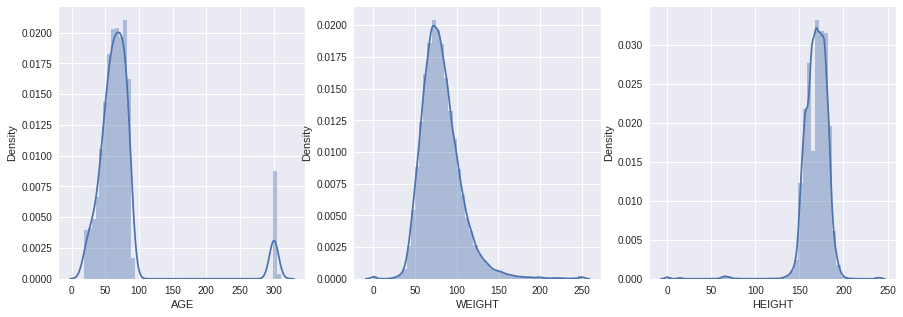

% with Age greater than 120: 0.053160185793147054
N with Age greater than 120: 2186


In [7]:
# explore outlier values for demographic continuous variables
plt.figure(figsize=(15,5))
plt.subplot(131)
sns.distplot(X.AGE)
plt.subplot(132)
sns.distplot(X.WEIGHT)
plt.subplot(133)
sns.distplot(X.HEIGHT)
plt.show()
print('% with Age greater than 120: {}'.format(np.mean(X.AGE>120)));
print('N with Age greater than 120: {}'.format(np.sum(X.AGE>120)));

In [8]:
# examine new feature covariate data
X.head()
X.shape
X.isna().sum()
y.isna().sum()
X.dtypes

,AGE,ETHNICITY_NUM,GENDER_NUM,HEIGHT,WEIGHT,HOURS,CAPILLARY REFILL RATE,DIASTOLIC BLOOD PRESSURE,FRACTION INSPIRED OXYGEN,GLASCOW COMA SCALE TOTAL,...,ADMIT_DIAG_SEPSIS,ADMIT_DIAG_HYPOXIA,ADMIT_DIAG_RESPIRATORY DISTRESS,GENDER_MALE,RACE_WHITE,RACE_HISPANIC,RACE_BLACK,RACE_ASIAN,RACE_OTHER_UNKNOWN,GENDER_FEMALE
0,53.719370,4,1,163.0,70.397478,33.374167,NaN,65.000000,0.500,NaN,...,0,0,0,0,1,0,0,0,0,1
1,77.275838,4,1,163.0,77.155999,17.868333,NaN,48.800000,NaN,NaN,...,0,0,0,0,1,0,0,0,0,1
2,77.341547,4,1,155.0,77.836387,58.261944,NaN,53.986301,0.625,NaN,...,0,0,0,0,1,0,0,0,0,1
3,74.349076,4,2,NaN,NaN,21.916667,NaN,53.068966,NaN,13.75,...,0,0,0,1,1,0,0,0,0,0
4,51.071869,2,1,NaN,208.000000,89.316667,NaN,72.369565,NaN,15.00,...,0,0,0,0,0,0,1,0,0,1


(41121, 59)

AGE                                                                                   0
ETHNICITY_NUM                                                                         0
GENDER_NUM                                                                            0
HEIGHT                                                                            31792
WEIGHT                                                                             7227
HOURS                                                                                 0
CAPILLARY REFILL RATE                                                             40475
DIASTOLIC BLOOD PRESSURE                                                            136
FRACTION INSPIRED OXYGEN                                                          30697
GLASCOW COMA SCALE TOTAL                                                          18524
GLUCOSE                                                                             675
HEART RATE                      

0

AGE                                                                               float64
ETHNICITY_NUM                                                                       int64
GENDER_NUM                                                                          int64
HEIGHT                                                                            float64
WEIGHT                                                                            float64
HOURS                                                                             float64
CAPILLARY REFILL RATE                                                             float64
DIASTOLIC BLOOD PRESSURE                                                          float64
FRACTION INSPIRED OXYGEN                                                          float64
GLASCOW COMA SCALE TOTAL                                                          float64
GLUCOSE                                                                           float64
HEART RATE

In [9]:
# finalize set of features to use for classification modeling
# X.fillna(0, inplace=True)
# y.fillna(0, inplace=True)

# set outlier age/weight/height values to NA for imputation
X.loc[(X.AGE > 110), 'AGE'] = np.nan
X.loc[(X.WEIGHT == 0), 'WEIGHT'] = np.nan
X.loc[(X.HEIGHT==0), 'HEIGHT'] = np.nan
cont_cols = dem_cont_cols
binary_cols = binary_dem_cols + binary_diag_cols + binary_admit_cols
features = cont_cols + binary_cols

## Experiment 1 - Define Cohort Summary Table with Feature Values by Outcome Status

In [10]:
# define functions for summarizing overall cohort by outcomes
def mean_std(x):
    return str(round(np.mean(x), 2)) +  ' (' + str(round(np.std(x), 1)) + ')'

def count_pct(x):
    return str(int(np.sum(x))) + ' (' + str(np.round(x.mean()*100, 1)) + '%)'

mortality_df = pd.concat([X, y], axis=1).rename(columns=({'MORTALITY_INHOSPITAL_STAY_LABEL': 'MORTALITY'}))
binary_dem_sum = mortality_df.groupby('MORTALITY')[binary_dem_cols].agg(lambda x: count_pct(x)).T

cont_dem_sum = mortality_df.groupby('MORTALITY')[dem_cont_cols].agg((('% NA', lambda x: round(x.isna().mean()*100, 2)), ('Mean (sd)', lambda x: mean_std(x)))).T
binary_dem_tbl = pd.concat([binary_dem_sum, cont_dem_sum], axis=0)
binary_dem_tbl = binary_dem_tbl.reset_index().rename(columns=({'index': 'level_0'}))
binary_dem_tbl['Group'] = list(np.repeat('Gender', 2)) + list(np.repeat('Race', 5)) + list(np.repeat('Age', 2)) + list(np.repeat('Height', 2)) + list(np.repeat('Weight', 2))
binary_dem_tbl = binary_dem_tbl.groupby(['Group', 'level_0']).first()
binary_dem_tbl
binary_dem_tbl.columns

MORTALITY                               0              1
Group  level_0                                          
Age    (AGE, % NA)                   4.73          10.35
       (AGE, Mean (sd))      61.63 (16.7)   68.67 (15.0)
Gender GENDER_FEMALE        16084 (43.7%)   2041 (47.2%)
       GENDER_MALE          20717 (56.3%)   2279 (52.8%)
Height (HEIGHT, % NA)               77.13          79.17
       (HEIGHT, Mean (sd))  169.01 (13.4)  167.46 (13.2)
Race   RACE_ASIAN              847 (2.3%)     116 (2.7%)
       RACE_BLACK            3663 (10.0%)     286 (6.6%)
       RACE_HISPANIC          1369 (3.7%)      82 (1.9%)
       RACE_OTHER_UNKNOWN    4501 (12.2%)    800 (18.5%)
       RACE_WHITE           26421 (71.8%)   3036 (70.3%)
Weight (WEIGHT, % NA)               17.77          16.41
       (WEIGHT, Mean (sd))    82.2 (24.1)   77.39 (23.4)

Index([0, 1], dtype='object', name='MORTALITY')

In [11]:
# define groups of variables for diagnoses/admission reasons and segment by mortality
binary_diag_tbl = mortality_df.groupby('MORTALITY')[binary_diag_cols + binary_admit_cols].agg(lambda x: count_pct(x)).T

binary_diag_groups = ['Cardiovascular', 'Diabetes/Metabolic',
                      'Respiratory', 'Kidney/GI & Liver',
                      'Infectious Disease', 'Surgical Complications/Shock',
                      'Stroke']
cardio_diags = ['ESSENTIAL HYPERTENSION',
                'HYPERTENSION WITH COMPLICATIONS AND SECONDARY HYPERTENSION',
                'ACUTE MYOCARDIAL INFARCTION',
                'CORONARY ATHEROSCLEROSIS AND OTHER HEART DISEASE',
                'CONDUCTION DISORDERS',
                'CARDIAC DYSRHYTHMIAS',
                'CONGESTIVE HEART FAILURE; NONHYPERTENSIVE']
diabetes_diags = ['DIABETES MELLITUS WITHOUT COMPLICATION',
                  'DIABETES MELLITUS WITH COMPLICATIONS',
                  'DISORDERS OF LIPID METABOLISM',
                  'FLUID AND ELECTROLYTE DISORDERS']
respiratory_diags = ['CHRONIC OBSTRUCTIVE PULMONARY DISEASE AND BRONCHIECTASIS',
                     'PLEURISY; PNEUMOTHORAX; PULMONARY COLLAPSE',
                     'RESPIRATORY FAILURE; INSUFFICIENCY; ARREST (ADULT)',
                     'OTHER LOWER RESPIRATORY DISEASE',
                     'OTHER UPPER RESPIRATORY DISEASE']
gi_kidney_liver_diags = ['OTHER LIVER DISEASES',
                         'GASTROINTESTINAL HEMORRHAGE',
                         'ACUTE AND UNSPECIFIED RENAL FAILURE',
                         'CHRONIC KIDNEY DISEASE']
infectious_diags = ['SEPTICEMIA (EXCEPT IN LABOR)',
                    'PNEUMONIA (EXCEPT THAT CAUSED BY TUBERCULOSIS OR SEXUALLY TRANSMITTED DISEASE)']
shock_comp_diags = ['COMPLICATIONS OF SURGICAL PROCEDURES OR MEDICAL CARE',
                    'SHOCK']
stroke_diags = ['ACUTE CEREBROVASCULAR DISEASE']
diag_group_lists = [cardio_diags, diabetes_diags, respiratory_diags, gi_kidney_liver_diags,
                    infectious_diags, shock_comp_diags, stroke_diags]
binary_diag_map = dict(zip(binary_diag_groups, diag_group_lists))

# define table with counts, percentages of variables for diagnoses by mortality
binary_diag_tbl = mortality_df.groupby('MORTALITY')[binary_diag_cols + binary_admit_cols].agg(lambda x: count_pct(x)).T
binary_diag_tbl = binary_diag_tbl.reset_index()
binary_diag_tbl.columns = ['level_0', '0', '1']
binary_diag_tbl['Group'] = 'NA'
for k,v in binary_diag_map.items():
    binary_diag_tbl.loc[(binary_diag_tbl.level_0.apply(lambda x: x in v)), 'Group'] = 'CCS Diagnoses: ' + k
    
binary_diag_tbl['level_0'] = binary_diag_tbl.level_0.apply(lambda x: x.split('ADMIT_DIAG_')[1] if 'ADMIT' in x else x)
binary_diag_tbl.loc[(binary_diag_tbl['Group'] == 'NA'), 'Group'] = 'Admission Reason'
binary_diag_tbl = binary_diag_tbl.groupby(['Group', 'level_0']).first()
binary_diag_tbl

0  \
Group                                       level_0                                                             
Admission Reason                            BRAIN_HEMORRHAGE                                       517 (1.4%)   
                                            CARDIAC_ARREST                                         105 (0.3%)   
                                            CEREBROVASCULAR ACCIDENT                                54 (0.1%)   
                                            HYPOXIA                                                 81 (0.2%)   
                                            LIVER FAILURE                                          107 (0.3%)   
                                            RESPIRATORY DISTRESS                                    96 (0.3%)   
                                            SEPSIS                                                 747 (2.0%)   
CCS Diagnoses: Cardiovascular               ACUTE MYOCARDIAL INFARCTION                          3708 (10.1%)   
                                            CARDIAC DYSRHYTHMIAS                                11486 (31.2%)   
                                            CONDUCTION DISORDERS                                  2603 (7.1%)   
                                            CONGESTIVE HEART FAILURE; NONHYPERTENSIVE            9482 (25.8%)   
                                            CORONARY ATHEROSCLEROSIS AND OTHER HEART DISEASE    12193 (33.1%)   
                                            ESSENTIAL HYPERTENSION                              15685 (42.6%)   
                                            HYPERTENSION WITH COMPLICATIONS AND SECONDARY H...   4738 (12.9%)   
CCS Diagnoses: Diabetes/Metabolic           DIABETES MELLITUS WITH COMPLICATIONS                  3597 (9.8%)   
                                            DIABETES MELLITUS WITHOUT COMPLICATION               7044 (19.1%)   
                                            DISORDERS OF LIPID METABOLISM                       11162 (30.3%)   
                                            FLUID AND ELECTROLYTE DISORDERS                      9195 (25.0%)   
CCS Diagnoses: Infectious Disease           PNEUMONIA (EXCEPT THAT CAUSED BY TUBERCULOSIS O...   4594 (12.5%)   
                                            SEPTICEMIA (EXCEPT IN LABOR)                         4332 (11.8%)   
CCS Diagnoses: Kidney/GI & Liver            ACUTE AND UNSPECIFIED RENAL FAILURE                  6911 (18.8%)   
                                            CHRONIC KIDNEY DISEASE                               4780 (13.0%)   
                                            GASTROINTESTINAL HEMORRHAGE                           2567 (7.0%)   
                                            OTHER LIVER DISEASES                                  2847 (7.7%)   
CCS Diagnoses: Respiratory                  CHRONIC OBSTRUCTIVE PULMONARY DISEASE AND BRONC...   4642 (12.6%)   
                                            OTHER LOWER RESPIRATORY DISEASE                       1892 (5.1%)   
                                            OTHER UPPER RESPIRATORY DISEASE                       1514 (4.1%)   
                                            PLEURISY; PNEUMOTHORAX; PULMONARY COLLAPSE            3139 (8.5%)   
                                            RESPIRATORY FAILURE; INSUFFICIENCY; ARREST (ADULT)   5361 (14.6%)   
CCS Diagnoses: Stroke                       ACUTE CEREBROVASCULAR DISEASE                         2248 (6.1%)   
CCS Diagnoses: Surgical Complications/Shock COMPLICATIONS OF SURGICAL PROCEDURES OR MEDICAL...   7823 (21.3%)   
                                            SHOCK                                                 2017 (5.5%)   

                                                                                                           1  
Group                                       level_0                                                           
Admission Reason                           

In [12]:
# combine demographic cohort summary with diagnoses/admission reason table
binary_dem_tbl.columns = ['0', '1']
mortality_cohort_table = pd.concat([binary_dem_tbl, binary_diag_tbl], axis=0)
mortality_cohort_table = mortality_cohort_table.reset_index()
mortality_cohort_table['level_0'] = mortality_cohort_table['level_0'].apply(lambda x: x.capitalize() if type(x)==str else x).apply(lambda x: x.split('Race_')[1] if 'Race' in x else x).apply(lambda x: x.split('Gender_')[1] if 'Gender' in x else x).apply(lambda x: x.capitalize() if type(x)==str else x)
groups = ['Gender', 'Race', 'Age', 'Height', 'Weight', 'Admission Reason'] + [x for x in mortality_cohort_table.Group.unique() if 'CCS' in x]
group_order = np.arange(0, len(groups), 1)
group_order_map = dict(zip(groups, group_order))
mortality_cohort_table['Group_Order'] = mortality_cohort_table.Group.apply(lambda x: group_order_map[x])
mortality_cohort_table = mortality_cohort_table.sort_values(by='Group_Order', ascending=True).drop('Group_Order', axis=1).reset_index(drop=True)
mortality_cohort_table.rename(columns=({'level_0': 'Name'}), inplace=True)
mortality_cohort_table

# write mortality cohort table to csv
#mortality_cohort_table.to_csv('../plots/MIMIC3_MORTALITY_COHORT_TABLE_ONE_20221120.csv', index=False)

,Group,Name,0,1
0,Gender,Female,16084 (43.7%),2041 (47.2%)
1,Gender,Male,20717 (56.3%),2279 (52.8%)
2,Race,Asian,847 (2.3%),116 (2.7%)
3,Race,Black,3663 (10.0%),286 (6.6%)
4,Race,Hispanic,1369 (3.7%),82 (1.9%)
5,Race,Other_unknown,4501 (12.2%),800 (18.5%)
6,Race,White,26421 (71.8%),3036 (70.3%)
7,Age,"(AGE, % NA)",4.73,10.35
8,Age,"(AGE, Mean (sd))",61.63 (16.7),68.67 (15.0)
9,Height,"(HEIGHT, % NA)",77.13,79.17


In [13]:
# functions for IQR with aggregation
def q25(x):
    return np.quantile(x, q=0.25)

def q75(x):
    return np.quantile(x, q=0.75)

def iqr(x):
    q_25, q_50, q_75 = np.round(np.quantile(x, q=[0.25, 0.50, 0.75]), 2)
    val = str(q_50) + ' (IQR: {}-{})'.format(q_25, q_75)
    return val

# summarize length of stay by variables
mean_los = []
sd_los = []
med_los = []
iqr_los = []
for col in binary_cols:
    mean_los.append(np.round(data[data[col]==1]['LOS_STAY_LABEL'].mean(), 2))
    med_los.append(np.round(np.median(data[data[col]==1]['LOS_STAY_LABEL']), 2))
    sd_los.append(np.round(np.std(data[data[col]==1]['LOS_STAY_LABEL']), 2))
    iqr_los.append(iqr(data[data[col]==1]['LOS_STAY_LABEL']))
binary_los_tbl = pd.DataFrame([binary_cols, mean_los, sd_los, med_los, iqr_los]).T
binary_los_tbl.columns = ['Name', 'Mean Length of Stay', 'Std. Deviation', 'Median Length of Stay', 'Median (IQR)']
binary_los_tbl = binary_los_tbl.iloc[:, [0, 1, 4]]
binary_los_tbl['Name'] = binary_los_tbl.Name.apply(lambda x: x.capitalize() if type(x)==str else x).apply(lambda x: x.split('Race_')[1] if 'Race' in x else x).apply(lambda x: x.split('Gender_')[1] if 'Gender' in x else x).apply(lambda x: x.split('Admit_diag_')[1] if 'Admit_diag' in x else x).apply(lambda x: x.capitalize() if type(x)==str else x)
binary_los_tbl

,Name,Mean Length of Stay,Median (IQR)
0,Male,3.64,1.99 (IQR: 1.16-3.74)
1,Female,3.63,2.05 (IQR: 1.17-3.78)
2,White,3.61,2.01 (IQR: 1.16-3.72)
3,Hispanic,3.24,1.89 (IQR: 1.12-3.36)
4,Black,3.42,1.99 (IQR: 1.16-3.41)
5,Asian,3.61,2.0 (IQR: 1.19-3.54)
6,Other_unknown,4.04,2.13 (IQR: 1.2-4.14)
7,Septicemia (except in labor),6.48,3.18 (IQR: 1.78-7.54)
8,Diabetes mellitus without complication,3.71,2.08 (IQR: 1.19-3.95)
9,Diabetes mellitus with complications,3.46,2.07 (IQR: 1.21-3.44)


In [14]:
# combine length of stay/mortality aggregations for table one description
mimic_cohort_table_one = mortality_cohort_table.merge(binary_los_tbl, on='Name', how='left')
mimic_cohort_table_one.columns = ['Group', 'Value', 'Mortality = 0', 'Mortality = 1', 'Mean Length of Stay (days)', 'Median (IQR) Length of Stay']
mimic_cohort_table_one['Group_Order'] = mimic_cohort_table_one.Group.apply(lambda x: group_order_map[x])
mimic_cohort_table_one = mimic_cohort_table_one.sort_values(by='Group_Order', ascending=True)#.drop('Group_Order', axis=1).reset_index(drop=True)
mimic_cohort_table_one = mimic_cohort_table_one.groupby(['Group', 'Value']).first().sort_values('Group_Order').drop('Group_Order', axis=1)
mimic_cohort_table_one
#mimic_cohort_table_one.to_csv('../plots/Tables/MIMIC3_MORTALITY_LOS_COHORT_TABLE_ONE_20221121.csv')

Mortality = 0  \
Group                                       Value                                                               
Gender                                      Male                                                20717 (56.3%)   
                                            Female                                              16084 (43.7%)   
Race                                        White                                               26421 (71.8%)   
                                            Other_unknown                                        4501 (12.2%)   
                                            Hispanic                                              1369 (3.7%)   
                                            Black                                                3663 (10.0%)   
                                            Asian                                                  847 (2.3%)   
Age                                         (AGE, % NA)                                                  4.73   
                                            (AGE, Mean (sd))                                     61.63 (16.7)   
Height                                      (HEIGHT, Mean (sd))                                 169.01 (13.4)   
                                            (HEIGHT, % NA)                                              77.13   
Weight                                      (WEIGHT, Mean (sd))                                   82.2 (24.1)   
                                            (WEIGHT, % NA)                                              17.77   
Admission Reason                            Brain_hemorrhage                                       517 (1.4%)   
                                            Cardiac_arrest                                         105 (0.3%)   
                                            Sepsis                                                 747 (2.0%)   
                                            Respiratory distress                                    96 (0.3%)   
                                            Liver failure                                          107 (0.3%)   
                                            Hypoxia                                                 81 (0.2%)   
                                            Cerebrovascular accident                                54 (0.1%)   
CCS Diagnoses: Cardiovascular               Acute myocardial infarction                          3708 (10.1%)   
                                            Coronary atherosclerosis and other heart disease    12193 (33.1%)   
                                            Cardiac dysrhythmias                                11486 (31.2%)   
                                            Essential hypertension                              15685 (42.6%)   
                                            Hypertension with complications and secondary h...   4738 (12.9%)   
                                            Congestive heart failure; nonhypertensive            9482 (25.8%)   
                                            Conduction disorders                                  2603 (7.1%)   
CCS Diagnoses: Diabetes/Metabolic           Fluid and electrolyte disorders                      9195 (25.0%)   
                                            Disorders of lipid metabolism                       11162 (30.3%)   
                                            Diabetes mellitus without complication               7044 (19.1%)   
                                            Diabetes mellitus with complications                  3597 (9.8%)   
CCS Diagnoses: Infectious Disease           Septicemia (except in labor)                         4332 (11.8%)   
                                            Pneumonia (except that caused by tuberculosis o...   4594 (12.5%)   
CCS Diagnoses: Kidney/GI & Liver            Acute and unspecified renal failure                  6911 (18.8%)   
                            

In [ ]:
# ayan_test_data = pd.concat([data[drop_cols[:3]], X[features]], axis=1).reset_index(drop=True)
# ayan_test_data
#tmp = ayan_test_data
# for col in ayan_test_data.iloc[:, 3:].columns.tolist():
#     minv = np.min(ayan_test_data.iloc[:, 3:][col])
#     maxv = np.max(ayan_test_data.iloc[:, 3:][col])
#     ayan_test_data.iloc[:, 3:][col] = np.random.randint(int(minv), int(maxv)+1, size=len(ayan_test_data))
# ayan_test_data.agg([np.min, np.max]).T
# ayan_test_data.agg([np.min, np.max]).mean().T
#ayan_test_data.iloc[np.random.random_integers(0, high=10000, size=len(ayan_test_data)), 3:]
#ayan_test_data.drop_duplicates(inplace=True)
#ayan_test_data.drop(['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID'], axis=1, inplace=True)
#ayan_test_data = ayan_test_data.fillna(0)
#ayan_test_data = ayan_test_data[:2000]
#ayan_test_data.mean()
#testids = pd.DataFrame(np.arange(0, len(ayan_test_data)))
#testids['HADM_ID'] = np.arange(0, len(testids))
#testids['ICUSTAY_ID'] = np.arange(0, len(testids))
#testids.rename_axis(columns={0:'SUBJECT_ID'}, inplace=True)
#testids.columns = ['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID']

In [ ]:
test_mimic_df = pd.concat([testids, ayan_test_data], axis=1)
test_mimic_df.to_csv('../data/MIMIC_III_TEST_DATA_FOR_AYAN.csv', index=False)

## Experiment 2: Comparing Performance of Nested vs. Non-Nested CV

### Experiment 2.01: Comparing Performance from Nested to non-Nested CV

In [14]:
import scipy.stats as st
import joblib
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler, QuantileTransformer, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier, RidgeClassifier, Perceptron
from sklearn.model_selection import KFold, StratifiedKFold, LeaveOneOut, LeavePOut
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedGroupKFold, GroupKFold, TimeSeriesSplit
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.feature_selection import RFECV, SelectKBest, SelectFdr, chi2, mutual_info_classif, RFE, SelectFromModel
from time import time
from sklearn.metrics import roc_auc_score, average_precision_score, label_ranking_loss, zero_one_loss
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold

# Number of random trials
NUM_TRIALS = 10

# Load the dataset defined above
X_exp1 = X[features].copy()
y_exp1 = y.copy()

# Set up possible values of parameters to optimize over
#p_grid = {"C": [1, 10, 100], "gamma": [0.01, 0.1]}

# We will use a Support Vector Classifier with "rbf" kernel
#svm = SVC(kernel="rbf", probability=True)
#svm = SVC(probability=True, kernel='rbf')
log_reg = LogisticRegression(solver='saga')

# Arrays to store scores
non_nested_scores = np.zeros(NUM_TRIALS)
nested_scores = np.zeros(NUM_TRIALS)

# Loop for each trial
for i in range(NUM_TRIALS):
    
    print('ROUND NUMBER: {}'.format(i))
    
    # define column transformers based on given feature subsets
    ss_cols = cont_cols # to use with standard scaler

    # combine transformers with Column Transformer
    ss = StandardScaler()

    overall_transformer = ColumnTransformer(
        transformers=[
            ("standard_scaler", ss, ss_cols),
        ]
    )
    
    #imputer = KNNImputer(missing_values=np.nan, n_neighbors=5)
    imputer = SimpleImputer(missing_values=np.nan, strategy='median')
    
    feature_selector = SelectKBest(mutual_info_classif, k=10)

    # pipeline requires ordered input for preprocessing
    pipe = Pipeline(steps=[('imputer', imputer),
                           ('preprocessor', ss),
                           ('select', feature_selector),
                           ('classify', log_reg)])

    # double underscore allows access to pipeline step
    pipe_params = {'classify__C': np.power(10., np.arange(-2,2)),
                   'classify__penalty': ['l1', 'l2']}

    # Choose cross-validation techniques for the inner and outer loops,
    # independently of the dataset.
    inner_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=i)
    outer_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=i)

    # Non nested parameter search and scoring
    clf = GridSearchCV(estimator=pipe, param_grid=pipe_params, cv=outer_cv, n_jobs=-1, scoring='average_precision')
    clf.fit(X_exp1, y_exp1)
    non_nested_scores[i] = clf.best_score_

    # Nested CV with parameter optimization
    clf = GridSearchCV(estimator=pipe, param_grid=pipe_params, cv=inner_cv, n_jobs=-1, scoring='average_precision')
    nested_score = cross_val_score(clf, X=X_exp1, y=y_exp1, cv=outer_cv, n_jobs=-1)
    nested_scores[i] = nested_score.mean()

score_difference = non_nested_scores - nested_scores

print(
    "Average difference of {:6f} with std. dev. of {:6f}.".format(
        score_difference.mean(), score_difference.std()
    )
)

ROUND NUMBER: 0


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('imputer',
                                        SimpleImputer(strategy='median')),
                                       ('preprocessor', StandardScaler()),
                                       ('select',
                                        SelectKBest(score_func=<function mutual_info_classif at 0x7f96e8cdcd30>)),
                                       ('classify',
                                        LogisticRegression(solver='saga'))]),
             n_jobs=-1,
             param_grid={'classify__C': array([ 0.01,  0.1 ,  1.  , 10.  ]),
                         'classify__penalty': ['l1', 'l2']},
             scoring='average_precision')

ROUND NUMBER: 1


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=1, shuffle=True),
             estimator=Pipeline(steps=[('imputer',
                                        SimpleImputer(strategy='median')),
                                       ('preprocessor', StandardScaler()),
                                       ('select',
                                        SelectKBest(score_func=<function mutual_info_classif at 0x7f96e8cdcd30>)),
                                       ('classify',
                                        LogisticRegression(solver='saga'))]),
             n_jobs=-1,
             param_grid={'classify__C': array([ 0.01,  0.1 ,  1.  , 10.  ]),
                         'classify__penalty': ['l1', 'l2']},
             scoring='average_precision')

ROUND NUMBER: 2


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=2, shuffle=True),
             estimator=Pipeline(steps=[('imputer',
                                        SimpleImputer(strategy='median')),
                                       ('preprocessor', StandardScaler()),
                                       ('select',
                                        SelectKBest(score_func=<function mutual_info_classif at 0x7f96e8cdcd30>)),
                                       ('classify',
                                        LogisticRegression(solver='saga'))]),
             n_jobs=-1,
             param_grid={'classify__C': array([ 0.01,  0.1 ,  1.  , 10.  ]),
                         'classify__penalty': ['l1', 'l2']},
             scoring='average_precision')

ROUND NUMBER: 3


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=3, shuffle=True),
             estimator=Pipeline(steps=[('imputer',
                                        SimpleImputer(strategy='median')),
                                       ('preprocessor', StandardScaler()),
                                       ('select',
                                        SelectKBest(score_func=<function mutual_info_classif at 0x7f96e8cdcd30>)),
                                       ('classify',
                                        LogisticRegression(solver='saga'))]),
             n_jobs=-1,
             param_grid={'classify__C': array([ 0.01,  0.1 ,  1.  , 10.  ]),
                         'classify__penalty': ['l1', 'l2']},
             scoring='average_precision')

ROUND NUMBER: 4


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=4, shuffle=True),
             estimator=Pipeline(steps=[('imputer',
                                        SimpleImputer(strategy='median')),
                                       ('preprocessor', StandardScaler()),
                                       ('select',
                                        SelectKBest(score_func=<function mutual_info_classif at 0x7f96e8cdcd30>)),
                                       ('classify',
                                        LogisticRegression(solver='saga'))]),
             n_jobs=-1,
             param_grid={'classify__C': array([ 0.01,  0.1 ,  1.  , 10.  ]),
                         'classify__penalty': ['l1', 'l2']},
             scoring='average_precision')

ROUND NUMBER: 5


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=5, shuffle=True),
             estimator=Pipeline(steps=[('imputer',
                                        SimpleImputer(strategy='median')),
                                       ('preprocessor', StandardScaler()),
                                       ('select',
                                        SelectKBest(score_func=<function mutual_info_classif at 0x7f96e8cdcd30>)),
                                       ('classify',
                                        LogisticRegression(solver='saga'))]),
             n_jobs=-1,
             param_grid={'classify__C': array([ 0.01,  0.1 ,  1.  , 10.  ]),
                         'classify__penalty': ['l1', 'l2']},
             scoring='average_precision')

ROUND NUMBER: 6


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=6, shuffle=True),
             estimator=Pipeline(steps=[('imputer',
                                        SimpleImputer(strategy='median')),
                                       ('preprocessor', StandardScaler()),
                                       ('select',
                                        SelectKBest(score_func=<function mutual_info_classif at 0x7f96e8cdcd30>)),
                                       ('classify',
                                        LogisticRegression(solver='saga'))]),
             n_jobs=-1,
             param_grid={'classify__C': array([ 0.01,  0.1 ,  1.  , 10.  ]),
                         'classify__penalty': ['l1', 'l2']},
             scoring='average_precision')

ROUND NUMBER: 7


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=7, shuffle=True),
             estimator=Pipeline(steps=[('imputer',
                                        SimpleImputer(strategy='median')),
                                       ('preprocessor', StandardScaler()),
                                       ('select',
                                        SelectKBest(score_func=<function mutual_info_classif at 0x7f96e8cdcd30>)),
                                       ('classify',
                                        LogisticRegression(solver='saga'))]),
             n_jobs=-1,
             param_grid={'classify__C': array([ 0.01,  0.1 ,  1.  , 10.  ]),
                         'classify__penalty': ['l1', 'l2']},
             scoring='average_precision')

ROUND NUMBER: 8


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=8, shuffle=True),
             estimator=Pipeline(steps=[('imputer',
                                        SimpleImputer(strategy='median')),
                                       ('preprocessor', StandardScaler()),
                                       ('select',
                                        SelectKBest(score_func=<function mutual_info_classif at 0x7f96e8cdcd30>)),
                                       ('classify',
                                        LogisticRegression(solver='saga'))]),
             n_jobs=-1,
             param_grid={'classify__C': array([ 0.01,  0.1 ,  1.  , 10.  ]),
                         'classify__penalty': ['l1', 'l2']},
             scoring='average_precision')

ROUND NUMBER: 9


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=9, shuffle=True),
             estimator=Pipeline(steps=[('imputer',
                                        SimpleImputer(strategy='median')),
                                       ('preprocessor', StandardScaler()),
                                       ('select',
                                        SelectKBest(score_func=<function mutual_info_classif at 0x7f96e8cdcd30>)),
                                       ('classify',
                                        LogisticRegression(solver='saga'))]),
             n_jobs=-1,
             param_grid={'classify__C': array([ 0.01,  0.1 ,  1.  , 10.  ]),
                         'classify__penalty': ['l1', 'l2']},
             scoring='average_precision')

Average difference of 0.002227 with std. dev. of 0.003020.


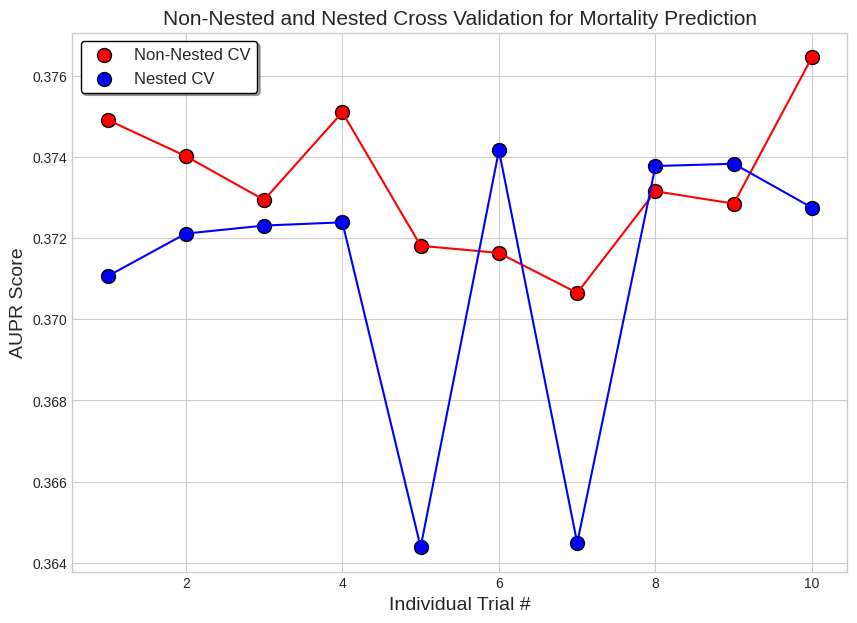

In [15]:
# plot scores on each trial for nested and non-nested CV
plt.style.use('default')
plt.style.use('seaborn-whitegrid')
sns.set_palette('bright')
plt.figure(figsize=(10,7))

# plot non-nested scores
plt.scatter(np.arange(1, 11), non_nested_scores, label='Non-Nested CV', edgecolors='k', s=100, color='r')
plt.plot(np.arange(1, 11), non_nested_scores, color="r")

# plot non-nested scores
plt.scatter(np.arange(1, 11), nested_scores, label='Nested CV', edgecolors='k', s=100, color='b')
plt.plot(np.arange(1, 11), nested_scores, color="b")

plt.ylabel("AUPR Score", size=14)
plt.xlabel("Individual Trial #", size=14)
plt.legend(fontsize=12, frameon=True, edgecolor='black', shadow=True, facecolor='white')
plt.title("Non-Nested and Nested Cross Validation for Mortality Prediction", size=15);
#plt.ylim([0, 0.5])
#plt.savefig('../plots/MORTALITY_NESTED_VS_NON_NESTED_CV_AUPR_TRIALS_5_FOLD_LOG_REGRESSION.png', dpi=300)
plt.show();

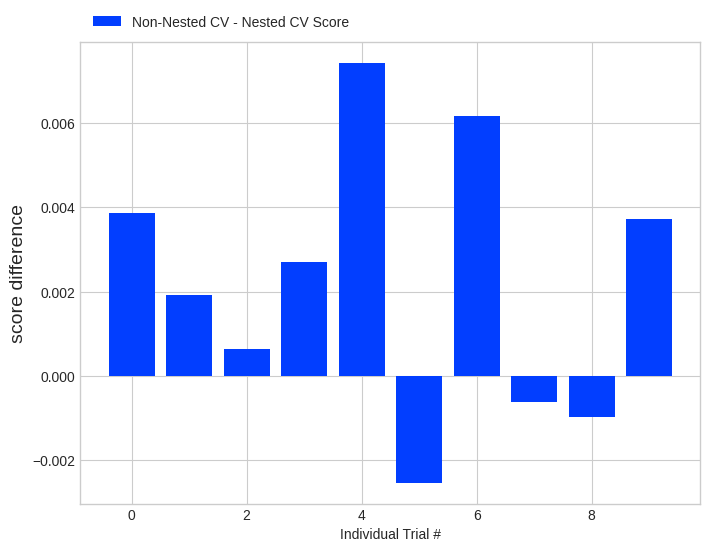

In [16]:
# Plot bar chart of the difference.
plt.figure(figsize=(8,6))
difference_plot = plt.bar(range(NUM_TRIALS), score_difference)
plt.xlabel("Individual Trial #")
plt.legend(
    [difference_plot],
    ["Non-Nested CV - Nested CV Score"],
    bbox_to_anchor=(0, 1, 0.8, 0),
)
plt.ylabel("score difference", fontsize="14")
plt.show();

In [17]:
# from sklearn.metrics import make_scorer, top_k_accuracy_score, accuracy_score
# from sklearn.tree import DecisionTreeClassifier
# model = DecisionTreeClassifier()
# scoring = {"AUC": "roc_auc", "Accuracy": make_scorer(accuracy_score)}
# gs = GridSearchCV(
#     DecisionTreeClassifier(random_state=42),
#     param_grid={"max_depth": [1, 5, 10]},
#     scoring=scoring,
#     refit="AUC",
#     n_jobs=2,
#     return_train_score=True,
# )
# gs.fit(X_exp1, y_exp1)
# results = gs.cv_results_

# gs_values = pd.DataFrame(results.items(), columns=['metric', 'value'])
# gs_values[gs_values.metric.apply(lambda x: 'split' in x and 'test_AUC' in x)]
# plt.plot(np.arange(6, 11), gs_values[(gs_values.metric.apply(lambda x: 'split' in x and 'test_AUC' in x))].iloc[:, 0].values)
#gs_values[x for x in gs_values.iloc[0, ].values if 'test_AUC' in gs_values.iloc[0, ].values]

### Experiment 2.02: AUROC/AUPR Boxplots & Run-Time for CV Methods

**NOTE: Use Ridge Classifier Instead of SVM?**
- only use either parameter tuning or feature selection and not both? (just drop all time series measurement features needing to be imputed) 

In [28]:
import scipy.stats as st
import joblib
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler, QuantileTransformer, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier, RidgeClassifier
from sklearn.model_selection import KFold, StratifiedKFold, LeaveOneOut, LeavePOut
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedGroupKFold, GroupKFold, TimeSeriesSplit
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.feature_selection import RFECV, SelectKBest, SelectFdr, chi2, mutual_info_classif, RFE, SelectFromModel
from time import time
from sklearn.metrics import roc_auc_score, average_precision_score, label_ranking_loss, zero_one_loss
from sklearn.impute import SimpleImputer, KNNImputer

# -----NESTED CROSS VALIDATION-----
def nested_cv(X, y, model='LogisticRegression', cpu_num=-1, n_folds=5, verbose=True,
              return_predictions=False, return_models=True, feature_selection=True, scaling=True,
              cont_cols=None, binary_cols=None, random_state=8888): # add imputation methods/Fselection options
    "Perform nested cross validation and get outcomes & predictions"
    
    # ----- NOTE: NEED TO FILL IN WITH YOUR FEATURE NAMES BELOW -----
    # define column transformers based on given feature subsets
    ss_cols = cont_cols # to use with standard scaler

    # combine transformers with Column Transformer
    ss = StandardScaler()

    overall_transformer = ColumnTransformer(
        transformers=[
            ("standard_scaler", ss, ss_cols),
        ]
    )
    
    #imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    imputer = SimpleImputer(missing_values=np.nan, strategy='median')
        
    #feature_selector = SelectFdr(mutual_info_classif)
    #feature_selector = SelectFromModel(LogisticRegression(n_jobs=-1))
    #feature_selector = RFE(mutual_info_classif)
    feature_selector = SelectKBest(mutual_info_classif, k=10)
    
    # specify classifier to use
    if model == 'LogisticRegression':
        clf = LogisticRegression(solver='saga', n_jobs=-1)
    elif model == 'RandomForest':
        clf = RandomForestClassifier(n_estimators=50, n_jobs=-1)
    else:
        print('Error: Must specify one of the acceptable classifiers')
        return

    # pipeline requires ordered input for preprocessing
    pipe = Pipeline(steps=[('imputer', imputer),
                           ('preprocessor', ss),
                           ('select', feature_selector),
                           ('classify', clf)])

    # double underscore allows access to pipeline step
    pipe_params = {'classify__C': np.power(10., np.arange(-2,2)),
                   'classify__penalty': ['l1', 'l2']}

    # reset indices
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    
    # initialize dictionary to hold CV results and classifiers
    start = time()
    result_dict = {}
    overall_preds = np.zeros(len(X))
    overall_clfs = []
    result_dict['estimator'] = []
    result_dict['test_roc_auc'] = []
    result_dict['test_average_precision'] = []
    
    # begin outer fold splitting
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=random_state)
    i = 1
    for train_index, test_index in skf.split(X, y):
        if verbose:
            print('OUTER FOLD ' + str(i) + ':')
        X_train = X.iloc[train_index, :]
        y_train = y[train_index]
        X_test = X.iloc[test_index, :]
        y_test = y[test_index]
        
        # run cv using training set from each outer fold split
        gscv = GridSearchCV(pipe, pipe_params, cv=n_folds, verbose=verbose, n_jobs=cpu_num,
                            scoring='average_precision', return_train_score=False, refit=True)
        gscv = gscv.fit(X_train, y_train)
        
        # get best classifier and predict on outer test set
        #cv_models = cv['estimator']
        #best_clf = cv_models[np.argmax(cv['test_average_precision'])]
        best_clf = gscv.best_estimator_
        y_pred = best_clf.predict_proba(X_test)[:, 1]
        result_dict['test_average_precision'].append(average_precision_score(y_true = y_test, y_score=y_pred))
        result_dict['test_roc_auc'].append(roc_auc_score(y_true = y_test, y_score=y_pred))
        result_dict['estimator'].append(best_clf)
        i += 1
        
    # print total time required
    total_time = time() - start
    if verbose:
        print('\nTOTAL RUNTIME (s): {}'.format(total_time))
        
    result_dict['total_runtime'] = total_time
    return result_dict
#     # get final preds and save models
#     if save_models:
#         for k, model_obj in enumerate(overall_clfs):
#             joblib.dump(model_obj, model_path  + subset_name + '_' + 'LassoRegression' + '_CV_' + str(k) + '.pkl')
        
#     # build result df
#     result_df = data[["PERSON_ID", "GRID", "OUTCOME"]]
#     result_df['PREDS'] = overall_preds
    
#     # optionally save results to csv
#     if save_final_results:
#         file_name = subset_name + '_' + 'LassoRegression' + '_EARLY_FUSION_PREDICTIONS.csv'
#         result_df.to_csv(preds_path + file_name, index=False)
    
#     # optionally return results
#     if return_results:
#         return result_df

In [29]:
# run nested cv results
cont_cols = dem_cont_cols
binary_cols = binary_dem_cols + binary_diag_cols + binary_admit_cols
features = cont_cols + binary_cols
X_exp2 = X[features].copy()
y_exp2 = y.copy()
nested_cv_results = nested_cv(X_exp2, y_exp2, cont_cols=cont_cols, binary_cols=binary_cols)
nested_cv_results

OUTER FOLD 1:
Fitting 5 folds for each of 8 candidates, totalling 40 fits
OUTER FOLD 2:
Fitting 5 folds for each of 8 candidates, totalling 40 fits
OUTER FOLD 3:
Fitting 5 folds for each of 8 candidates, totalling 40 fits
OUTER FOLD 4:
Fitting 5 folds for each of 8 candidates, totalling 40 fits
OUTER FOLD 5:
Fitting 5 folds for each of 8 candidates, totalling 40 fits

TOTAL RUNTIME (s): 186.35187911987305


{'estimator': [Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                  ('preprocessor', StandardScaler()),
                  ('select',
                   SelectKBest(score_func=<function mutual_info_classif at 0x7f96e8cdcd30>)),
                  ('classify',
                   LogisticRegression(n_jobs=-1, penalty='l1', solver='saga'))]),
  Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                  ('preprocessor', StandardScaler()),
                  ('select',
                   SelectKBest(score_func=<function mutual_info_classif at 0x7f96e8cdcd30>)),
                  ('classify',
                   LogisticRegression(C=10.0, n_jobs=-1, solver='saga'))]),
  Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                  ('preprocessor', StandardScaler()),
                  ('select',
                   SelectKBest(score_func=<function mutual_info_classif at 0x7f96e8cdcd30>)),
                  ('classify',
          

**NOTE: Use same grid search CV method with non-nested approaches and get AUROC/AUPR values from each fold**

In [30]:
# define methods to use for cross validation
kf = KFold(n_splits=5, shuffle=True)
skf = StratifiedKFold(n_splits=5, shuffle=True)
loo = LeaveOneOut() # Note: LOOCV runs ~35,000 times with this dataset
repeated_kf = RepeatedKFold(n_repeats=10, n_splits=5)
repeated_skf = RepeatedStratifiedKFold(n_repeats=10, n_splits=5)

#cv_methods = [kf, skf, loo, repeated_kf, repeated_skf]
#cv_names = ['KFold', 'StratifiedKFold', 'LeaveOneOut', 'RepeatedKFold', 'RepeatedStratifiedKFold']
cv_methods = [kf, skf, repeated_kf, repeated_skf]
cv_names = ['KFoldCV', 'StratifiedCV', 'RepeatedCV', 'RepeatedStratifiedCV']
cv_types = dict(zip(cv_names, cv_methods))

# define column transformers based on given feature subsets
ss_cols = cont_cols # to use with standard scaler

# combine transformers with Column Transformer
ss = StandardScaler()

overall_transformer = ColumnTransformer(
    transformers=[
        ("standard_scaler", ss, ss_cols),
    ]
)

#imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imputer = SimpleImputer(missing_values=np.nan, strategy='median')

#feature_selector = SelectFdr(mutual_info_classif)
#feature_selector = SelectFromModel(LogisticRegression(n_jobs=-1))
#feature_selector = RFE(mutual_info_classif)
feature_selector = SelectKBest(mutual_info_classif, k=10)

# specify classifier to use
model = 'LogisticRegression'
if model == 'LogisticRegression':
    clf = LogisticRegression(solver='saga', n_jobs=-1)
elif model == 'RandomForest':
    clf = RandomForestClassifier(n_estimators=50, n_jobs=-1)
else:
    print('Must specify one of the allowed classifiers')
    pass
    

# pipeline requires ordered input for preprocessing
pipe = Pipeline(steps=[('imputer', imputer),
                       ('preprocessor', ss),
                       ('select', feature_selector),
                       ('classify', clf)])

# double underscore allows access to pipeline step
pipe_params = {'classify__C': np.power(10., np.arange(-2,2)),
               'classify__penalty': ['l1', 'l2']}

cv_dict = {}
cv_dfs = []
cv_run_times = []
cv_types = dict(zip(cv_names, cv_methods))
for name, split_fn in cv_types.items():
    print(name)
    start_time = time()
    cv = GridSearchCV(pipe, pipe_params, cv=split_fn, verbose=True, n_jobs=-1,
                      scoring=['average_precision', 'roc_auc'], return_train_score=False, refit=False)
    cv = cv.fit(X_exp2, y_exp2)
    cv = cv.cv_results_
    total_time = time() - start_time
    cv['total_runtime'] = total_time
    cv_run_times.append(total_time)
    cv_dict[name] = cv
    df = pd.DataFrame(cv)
    df['method'] = name
    cv_dfs.append(df)

KFoldCV
Fitting 5 folds for each of 8 candidates, totalling 40 fits
StratifiedCV
Fitting 5 folds for each of 8 candidates, totalling 40 fits
RepeatedCV
Fitting 50 folds for each of 8 candidates, totalling 400 fits
RepeatedStratifiedCV
Fitting 50 folds for each of 8 candidates, totalling 400 fits


In [31]:
# make sure we have both reasonable mean discrimination values for next plots
cv_dict['NestedCV'] = nested_cv_results
cv_names = cv_dict.keys()
for name in cv_names:
    print(name)
    print(cv_dict[name])

KFoldCV
{'mean_fit_time': array([18.54279809, 18.3301599 , 18.55094399, 18.19684253, 17.56740303,
       14.6519331 , 14.22467356, 14.16693788]), 'std_fit_time': array([0.19360839, 0.41697786, 0.24921696, 0.18629438, 1.4538163 ,
       0.37009021, 0.33204259, 0.32871184]), 'mean_score_time': array([0.03636775, 0.03536758, 0.05452185, 0.03852   , 0.04053717,
       0.02302194, 0.02620277, 0.02674875]), 'std_score_time': array([0.00261179, 0.0040297 , 0.00464931, 0.00352629, 0.01071102,
       0.00138259, 0.00189405, 0.00388366]), 'param_classify__C': masked_array(data=[0.01, 0.01, 0.1, 0.1, 1.0, 1.0, 10.0, 10.0],
             mask=[False, False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_classify__penalty': masked_array(data=['l1', 'l2', 'l1', 'l2', 'l1', 'l2', 'l1', 'l2'],
             mask=[False, False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'classify__C': 0.01, 

In [32]:
# view results
cv_dict
nested_cv_df = pd.DataFrame(nested_cv_results)
cols = list(cv_dfs[0].columns)
for col in cols:
    if col not in nested_cv_df.columns:
        if col=='method':
            nested_cv_df[col] = 'NestedCV'
        else:
            nested_cv_df[col] = np.nan
nested_cv_df = nested_cv_df[cols]
cv_dfs.append(nested_cv_df)
cv_results = pd.concat(cv_dfs)
cv_results

{'KFoldCV': {'mean_fit_time': array([18.54279809, 18.3301599 , 18.55094399, 18.19684253, 17.56740303,
         14.6519331 , 14.22467356, 14.16693788]),
  'std_fit_time': array([0.19360839, 0.41697786, 0.24921696, 0.18629438, 1.4538163 ,
         0.37009021, 0.33204259, 0.32871184]),
  'mean_score_time': array([0.03636775, 0.03536758, 0.05452185, 0.03852   , 0.04053717,
         0.02302194, 0.02620277, 0.02674875]),
  'std_score_time': array([0.00261179, 0.0040297 , 0.00464931, 0.00352629, 0.01071102,
         0.00138259, 0.00189405, 0.00388366]),
  'param_classify__C': masked_array(data=[0.01, 0.01, 0.1, 0.1, 1.0, 1.0, 10.0, 10.0],
               mask=[False, False, False, False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'param_classify__penalty': masked_array(data=['l1', 'l2', 'l1', 'l2', 'l1', 'l2', 'l1', 'l2'],
               mask=[False, False, False, False, False, False, False, False],
         fill_value='?',
              dtype=object),

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classify__C,param_classify__penalty,params,split0_test_average_precision,split1_test_average_precision,split2_test_average_precision,...,split40_test_roc_auc,split41_test_roc_auc,split42_test_roc_auc,split43_test_roc_auc,split44_test_roc_auc,split45_test_roc_auc,split46_test_roc_auc,split47_test_roc_auc,split48_test_roc_auc,split49_test_roc_auc
0,18.542798,0.193608,0.036368,0.002612,0.01,l1,"{'classify__C': 0.01, 'classify__penalty': 'l1'}",0.362720,0.373176,0.347647,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,18.330160,0.416978,0.035368,0.004030,0.01,l2,"{'classify__C': 0.01, 'classify__penalty': 'l2'}",0.354592,0.382701,0.350499,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,18.550944,0.249217,0.054522,0.004649,0.1,l1,"{'classify__C': 0.1, 'classify__penalty': 'l1'}",0.364818,0.382461,0.353521,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,18.196843,0.186294,0.038520,0.003526,0.1,l2,"{'classify__C': 0.1, 'classify__penalty': 'l2'}",0.368139,0.382356,0.355250,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,17.567403,1.453816,0.040537,0.010711,1.0,l1,"{'classify__C': 1.0, 'classify__penalty': 'l1'}",0.364114,0.395198,0.353470,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,14.651933,0.370090,0.023022,0.001383,1.0,l2,"{'classify__C': 1.0, 'classify__penalty': 'l2'}",0.374725,0.362716,0.346653,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,14.224674,0.332043,0.026203,0.001894,10.0,l1,"{'classify__C': 10.0, 'classify__penalty': 'l1'}",0.374738,0.382103,0.342676,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,14.166938,0.328712,0.026749,0.003884,10.0,l2,"{'classify__C': 10.0, 'classify__penalty': 'l2'}",0.374722,0.373058,0.353459,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,18.487908,0.117021,0.059919,0.019066,0.01,l1,"{'classify__C': 0.01, 'classify__penalty': 'l1'}",0.367424,0.389730,0.373173,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,18.201572,0.079055,0.039516,0.005514,0.01,l2,"{'classify__C': 0.01, 'classify__penalty': 'l2'}",0.382571,0.390019,0.371672,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
# examine performance/runtime results
run_time_dict = {}
auc_dict = {}
# store mean and standard deviation AUPR/AUROC
#cv_names.append('NestedCV')
for cv_method in cv_names:
    if 'Nested' in cv_method:
        continue
    print(cv_method)
    if 'Repeated' in cv_method:
        n_splits = 50
    else:
        n_splits = 5
    auc_dict[cv_method] = {}
    # get aupr/auroc scores from best grid search configuration model
    best_aupr_index = np.argmin(cv_dict[cv_method]['rank_test_average_precision'])
    best_auprs = []
    best_auroc_index = np.argmin(cv_dict[cv_method]['rank_test_roc_auc'])
    best_aurocs = []
    for i in range(n_splits):
        aupr = cv_dict[cv_method]['split' + str(i) + '_test_average_precision'][best_aupr_index]
        best_auprs.append(aupr)
        auroc = cv_dict[cv_method]['split' + str(i) + '_test_roc_auc'][best_auroc_index]
        best_aurocs.append(auroc)
    mean_aupr = np.mean(best_auprs)
    std_aupr = np.std(best_auprs)
    mean_auroc = np.mean(best_aurocs)
    std_auroc = np.std(best_aurocs)
    auc_dict[cv_method]['mean_aupr'] = round(mean_aupr, 3)
    auc_dict[cv_method]['std_aupr'] = round(std_aupr, 3)
    auc_dict[cv_method]['best_auprs'] = best_auprs
    auc_dict[cv_method]['mean_auroc'] = round(mean_auroc, 3)
    auc_dict[cv_method]['std_auroc'] = round(std_auroc, 3)
    auc_dict[cv_method]['best_aurocs'] = best_aurocs
    run_time_dict[cv_method] = cv_dict[cv_method]['total_runtime']
auc_dict
run_time_dict

KFoldCV
StratifiedCV
RepeatedCV
RepeatedStratifiedCV


{'KFoldCV': {'mean_aupr': 0.373,
  'std_aupr': 0.013,
  'best_auprs': [0.3681390259834411,
   0.3823557896736601,
   0.3552504553005846,
   0.3670130309617281,
   0.39316371608853934],
  'mean_auroc': 0.82,
  'std_auroc': 0.007,
  'best_aurocs': [0.8210613022351797,
   0.8290940687680484,
   0.8157883091282133,
   0.8097243127085448,
   0.8236080764995538]},
 'StratifiedCV': {'mean_aupr': 0.374,
  'std_aupr': 0.015,
  'best_auprs': [0.38114810487091855,
   0.3985755891123251,
   0.37192877544198255,
   0.3536683748358835,
   0.3645991325508279],
  'mean_auroc': 0.82,
  'std_auroc': 0.008,
  'best_aurocs': [0.8190583537109994,
   0.8340520738979468,
   0.8088124150815217,
   0.8169089988425926,
   0.8204213214573268]},
 'RepeatedCV': {'mean_aupr': 0.371,
  'std_aupr': 0.015,
  'best_auprs': [0.3773678152294901,
   0.3483549454157419,
   0.37502780579170597,
   0.3783412338153488,
   0.3596660222500367,
   0.3961750385720179,
   0.3876413656849973,
   0.38790775453327897,
   0.3457310897

{'KFoldCV': 33.557666301727295,
 'StratifiedCV': 33.81438636779785,
 'RepeatedCV': 305.0788540840149,
 'RepeatedStratifiedCV': 304.6719675064087}

In [34]:
nested_cv_results

{'estimator': [Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                  ('preprocessor', StandardScaler()),
                  ('select',
                   SelectKBest(score_func=<function mutual_info_classif at 0x7f96e8cdcd30>)),
                  ('classify',
                   LogisticRegression(n_jobs=-1, penalty='l1', solver='saga'))]),
  Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                  ('preprocessor', StandardScaler()),
                  ('select',
                   SelectKBest(score_func=<function mutual_info_classif at 0x7f96e8cdcd30>)),
                  ('classify',
                   LogisticRegression(C=10.0, n_jobs=-1, solver='saga'))]),
  Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                  ('preprocessor', StandardScaler()),
                  ('select',
                   SelectKBest(score_func=<function mutual_info_classif at 0x7f96e8cdcd30>)),
                  ('classify',
          

In [35]:
# add nested CV results to non-nested CV methods
nested_mean_aupr = np.mean(nested_cv_results['test_average_precision'])
nested_mean_auroc = np.mean(nested_cv_results['test_roc_auc'])
nested_std_aupr = np.std(nested_cv_results['test_average_precision'])
nested_std_auroc = np.std(nested_cv_results['test_roc_auc'])

auc_dict['NestedCV'] = {'mean_aupr': round(nested_mean_aupr, 3),
                        'std_aupr': round(nested_std_aupr, 3),
                        'mean_auroc': round(nested_mean_auroc, 3),
                        'std_auroc': round(nested_std_auroc, 3),
                        'best_auprs': nested_cv_results['test_average_precision'],
                        'best_aurocs': nested_cv_results['test_roc_auc']}
run_time_dict['NestedCV'] = nested_cv_results['total_runtime']

In [36]:
# add labels with mean/std values for legend
auroc_labels = [cv_name + ' (' + str(auc_dict[cv_name]['mean_auroc']) + ' +/- ' + str(auc_dict[cv_name]['std_auroc']) + ')' for cv_name in cv_names]
aupr_labels= [cv_name + ' (' + str(auc_dict[cv_name]['mean_aupr']) + ' +/- ' + str(auc_dict[cv_name]['std_aupr']) + ')' for cv_name in cv_names]
plot_cv_dfs = []
for cv_method in cv_names:
    print(cv_method)
    aupr_label = [x for x in aupr_labels if x.split(' ')[0] == cv_method]
    print(aupr_label)
    auroc_label = [x for x in auroc_labels if x.split(' ')[0] == cv_method]
    if 'Repeated' in cv_method:
        n_splits = 50
    else:
        n_splits = 5
    plot_cv_df = pd.DataFrame(np.repeat(cv_method, n_splits))
    plot_cv_df['auprs'] = auc_dict[cv_method]['best_auprs']
    plot_cv_df['aurocs'] = auc_dict[cv_method]['best_aurocs']
    plot_cv_df['aupr_label'] = np.repeat(aupr_label, n_splits)
    plot_cv_df['auroc_label'] = np.repeat(auroc_label, n_splits)
    plot_cv_dfs.append(plot_cv_df)
plot_cv_results = pd.concat(plot_cv_dfs)
plot_cv_results = plot_cv_results.rename(columns=({0: 'method'}))
plot_cv_results

KFoldCV
['KFoldCV (0.373 +/- 0.013)']
StratifiedCV
['StratifiedCV (0.374 +/- 0.015)']
RepeatedCV
['RepeatedCV (0.371 +/- 0.015)']
RepeatedStratifiedCV
['RepeatedStratifiedCV (0.37 +/- 0.013)']
NestedCV
['NestedCV (0.371 +/- 0.012)']


,method,auprs,aurocs,aupr_label,auroc_label
0,KFoldCV,0.368139,0.821061,KFoldCV (0.373 +/- 0.013),KFoldCV (0.82 +/- 0.007)
1,KFoldCV,0.382356,0.829094,KFoldCV (0.373 +/- 0.013),KFoldCV (0.82 +/- 0.007)
2,KFoldCV,0.355250,0.815788,KFoldCV (0.373 +/- 0.013),KFoldCV (0.82 +/- 0.007)
3,KFoldCV,0.367013,0.809724,KFoldCV (0.373 +/- 0.013),KFoldCV (0.82 +/- 0.007)
4,KFoldCV,0.393164,0.823608,KFoldCV (0.373 +/- 0.013),KFoldCV (0.82 +/- 0.007)
...,...,...,...,...,...
0,NestedCV,0.366881,0.814849,NestedCV (0.371 +/- 0.012),NestedCV (0.817 +/- 0.008)
1,NestedCV,0.360976,0.811368,NestedCV (0.371 +/- 0.012),NestedCV (0.817 +/- 0.008)
2,NestedCV,0.367201,0.816482,NestedCV (0.371 +/- 0.012),NestedCV (0.817 +/- 0.008)
3,NestedCV,0.365316,0.811077,NestedCV (0.371 +/- 0.012),NestedCV (0.817 +/- 0.008)


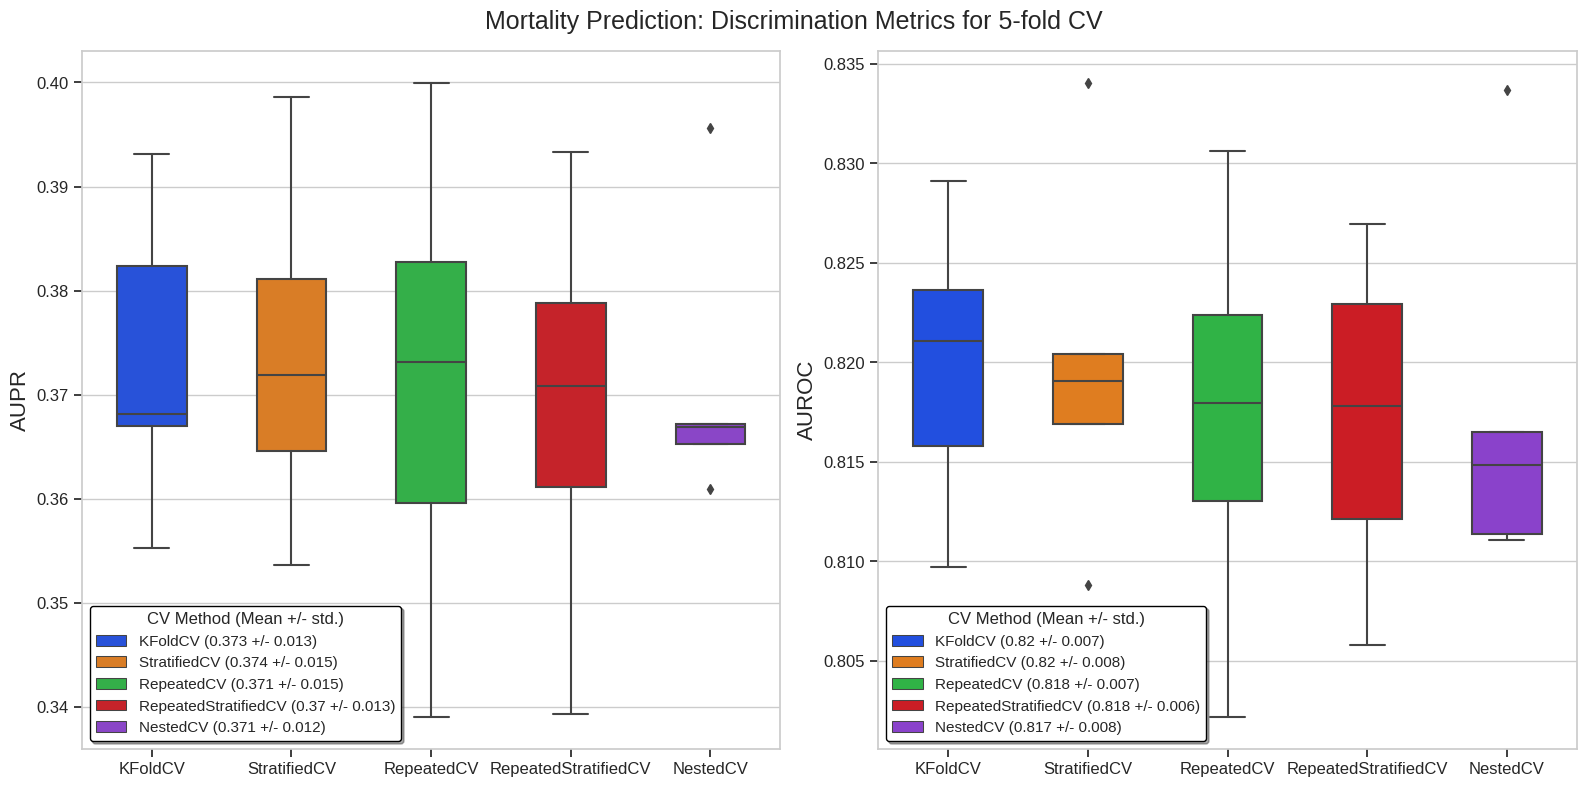

In [37]:
# plot AUROC/AUPR results from 5-fold CV
plt.style.reload_library()
plt.style.use('default')
plt.style.use('seaborn-whitegrid')
#plt.style.use('bmh')
sns.set_palette('bright')
sns.set_context('notebook')
plt.figure(figsize=(16, 8))
plt.subplot(121)
sns.boxplot(data=plot_cv_results, x='method', y='auprs', hue='aupr_label', dodge=False,
            width=0.5, whis=1.5, saturation=0.7)
plt.legend(frameon=True, edgecolor='black', shadow=True, fontsize=11, title='CV Method (Mean +/- std.)',
           facecolor='white')
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel('')
plt.ylabel('AUPR', size=16)
plt.subplot(122)
sns.boxplot(data=plot_cv_results, x='method', y='aurocs', hue='auroc_label', dodge=False,
            width=0.5, whis=1.5)
plt.legend(frameon=True, edgecolor='black', shadow=True, fontsize=11, title='CV Method (Mean +/- std.)',
           facecolor='white')
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel('')
plt.ylabel('AUROC', size=16)
plt.suptitle('Mortality Prediction: Discrimination Metrics for 5-fold CV', size=18)
plt.tight_layout(True)
plt.savefig('../plots/MORTALITY_AUPR_AUROC_BOXPLOTS_5_FOLD_CV_UPDATED_PARAMETER_TUNING_LOG_REGRESSION.png', dpi=300)
plt.show();

## Experiment 3: Estimate of True Test Error

- Define 20% validation set and run CV on remaining 80% <br>
- Run CV with different methods and return best estimators <br>
- Predict on validation set with best CV estimator and compare results to within-CV metrics

In [38]:
# split data into separate validation set (use to estimate true test error)
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_exp2, y_exp2, random_state=8888, shuffle=True,
                                                  stratify=y_exp2, test_size=0.2)

# examine training dataset (to use with CV) and validation dataset
X_train.head()
X_train.shape
y_train.head()
y_train.shape
y_train.mean()

X_val.head()
X_val.shape
y_val.head()
y_val.shape
y_val.mean()

,AGE,HEIGHT,WEIGHT,GENDER_MALE,GENDER_FEMALE,RACE_WHITE,RACE_HISPANIC,RACE_BLACK,RACE_ASIAN,RACE_OTHER_UNKNOWN,...,CHRONIC KIDNEY DISEASE,COMPLICATIONS OF SURGICAL PROCEDURES OR MEDICAL CARE,SHOCK,ADMIT_DIAG_CARDIAC_ARREST,ADMIT_DIAG_BRAIN_HEMORRHAGE,ADMIT_DIAG_LIVER FAILURE,ADMIT_DIAG_CEREBROVASCULAR ACCIDENT,ADMIT_DIAG_SEPSIS,ADMIT_DIAG_HYPOXIA,ADMIT_DIAG_RESPIRATORY DISTRESS
4272,54.212183,175.0,105.777654,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9444,71.865845,NaN,106.775557,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19882,59.129363,NaN,155.000000,1,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
40384,84.665298,178.0,83.460928,1,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
15487,82.083504,NaN,87.599998,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(32896, 42)

4272     0
9444     0
19882    0
40384    0
15487    0
Name: MORTALITY_INHOSPITAL_STAY_LABEL, dtype: int64

(32896,)

0.10505836575875487

,AGE,HEIGHT,WEIGHT,GENDER_MALE,GENDER_FEMALE,RACE_WHITE,RACE_HISPANIC,RACE_BLACK,RACE_ASIAN,RACE_OTHER_UNKNOWN,...,CHRONIC KIDNEY DISEASE,COMPLICATIONS OF SURGICAL PROCEDURES OR MEDICAL CARE,SHOCK,ADMIT_DIAG_CARDIAC_ARREST,ADMIT_DIAG_BRAIN_HEMORRHAGE,ADMIT_DIAG_LIVER FAILURE,ADMIT_DIAG_CEREBROVASCULAR ACCIDENT,ADMIT_DIAG_SEPSIS,ADMIT_DIAG_HYPOXIA,ADMIT_DIAG_RESPIRATORY DISTRESS
39878,NaN,163.0,68.356314,0,1,1,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
846,43.047228,NaN,NaN,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
14438,32.071184,NaN,NaN,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
16189,47.373032,NaN,74.200000,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
15304,38.042437,163.0,167.647603,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


(8225, 42)

39878    0
846      0
14438    0
16189    0
15304    0
Name: MORTALITY_INHOSPITAL_STAY_LABEL, dtype: int64

(8225,)

0.10504559270516717

In [39]:
# define methods to use for cross validation
kf = KFold(n_splits=5, shuffle=True)
skf = StratifiedKFold(n_splits=5, shuffle=True)
loo = LeaveOneOut() # Note: LOOCV runs ~35,000 times with this dataset
repeated_kf = RepeatedKFold(n_repeats=10, n_splits=5)
repeated_skf = RepeatedStratifiedKFold(n_repeats=10, n_splits=5)

#cv_methods = [kf, skf, loo, repeated_kf, repeated_skf]
#cv_names = ['KFold', 'StratifiedKFold', 'LeaveOneOut', 'RepeatedKFold', 'RepeatedStratifiedKFold']
cv_methods = [kf, skf, repeated_kf, repeated_skf]
cv_names = ['KFoldCV', 'StratifiedCV', 'RepeatedCV', 'RepeatedStratifiedCV']
cv_types = dict(zip(cv_names, cv_methods))

# define column transformers based on given feature subsets
ss_cols = cont_cols # to use with standard scaler

# combine transformers with Column Transformer
ss = StandardScaler()

overall_transformer = ColumnTransformer(
    transformers=[
        ("standard_scaler", ss, ss_cols),
    ]
)

#imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imputer = SimpleImputer(missing_values=np.nan, strategy='median')

#feature_selector = SelectFdr(mutual_info_classif)
#feature_selector = SelectFromModel(LogisticRegression(n_jobs=-1))
#feature_selector = RFE(mutual_info_classif)
feature_selector = SelectKBest(mutual_info_classif, k=10)

# specify classifier to use
model = 'LogisticRegression'
if model == 'LogisticRegression':
    clf = LogisticRegression(solver='saga', n_jobs=-1)
elif model == 'RandomForest':
    clf = RandomForestClassifier(n_estimators=50, n_jobs=-1)
else:
    print('Must specify one of the allowed classifiers')
    pass
    
# pipeline requires ordered input for preprocessing
pipe = Pipeline(steps=[('imputer', imputer),
                       ('preprocessor', ss),
                       ('select', feature_selector),
                       ('classify', clf)])

# double underscore allows access to pipeline step
pipe_params = {'classify__C': np.power(10., np.arange(-2,2)),
               'classify__penalty': ['l1', 'l2']}

cv_dict = {}
cv_dfs = []
cv_run_times = []
cv_types = dict(zip(cv_names, cv_methods))
for name, split_fn in cv_types.items():
    print(name)
    start_time = time()
    gs = GridSearchCV(pipe, pipe_params, cv=split_fn, verbose=True, n_jobs=-1,
                      scoring=['average_precision', 'roc_auc'],
                      return_train_score=False, refit="average_precision")
    gs.fit(X_train, y_train)
    cv = gs.cv_results_
    total_time = time() - start_time
    cv['total_runtime'] = total_time
    cv_run_times.append(total_time)
    df = pd.DataFrame(cv)
    df['method'] = name
    cv_dfs.append(df)
    cv['gs_best_score_'] = gs.best_score_
    cv['gs_best_estimator_'] = gs.best_estimator_
    cv_dict[name] = cv

KFoldCV
Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('imputer',
                                        SimpleImputer(strategy='median')),
                                       ('preprocessor', StandardScaler()),
                                       ('select',
                                        SelectKBest(score_func=<function mutual_info_classif at 0x7f96e8cdcd30>)),
                                       ('classify',
                                        LogisticRegression(n_jobs=-1,
                                                           solver='saga'))]),
             n_jobs=-1,
             param_grid={'classify__C': array([ 0.01,  0.1 ,  1.  , 10.  ]),
                         'classify__penalty': ['l1', 'l2']},
             refit='average_precision',
             scoring=['average_precision', 'roc_auc'], verbose=True)

StratifiedCV
Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('imputer',
                                        SimpleImputer(strategy='median')),
                                       ('preprocessor', StandardScaler()),
                                       ('select',
                                        SelectKBest(score_func=<function mutual_info_classif at 0x7f96e8cdcd30>)),
                                       ('classify',
                                        LogisticRegression(n_jobs=-1,
                                                           solver='saga'))]),
             n_jobs=-1,
             param_grid={'classify__C': array([ 0.01,  0.1 ,  1.  , 10.  ]),
                         'classify__penalty': ['l1', 'l2']},
             refit='average_precision',
             scoring=['average_precision', 'roc_auc'], verbose=True)

RepeatedCV
Fitting 50 folds for each of 8 candidates, totalling 400 fits


GridSearchCV(cv=RepeatedKFold(n_repeats=10, n_splits=5, random_state=None),
             estimator=Pipeline(steps=[('imputer',
                                        SimpleImputer(strategy='median')),
                                       ('preprocessor', StandardScaler()),
                                       ('select',
                                        SelectKBest(score_func=<function mutual_info_classif at 0x7f96e8cdcd30>)),
                                       ('classify',
                                        LogisticRegression(n_jobs=-1,
                                                           solver='saga'))]),
             n_jobs=-1,
             param_grid={'classify__C': array([ 0.01,  0.1 ,  1.  , 10.  ]),
                         'classify__penalty': ['l1', 'l2']},
             refit='average_precision',
             scoring=['average_precision', 'roc_auc'], verbose=True)

RepeatedStratifiedCV
Fitting 50 folds for each of 8 candidates, totalling 400 fits


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=5, random_state=None),
             estimator=Pipeline(steps=[('imputer',
                                        SimpleImputer(strategy='median')),
                                       ('preprocessor', StandardScaler()),
                                       ('select',
                                        SelectKBest(score_func=<function mutual_info_classif at 0x7f96e8cdcd30>)),
                                       ('classify',
                                        LogisticRegression(n_jobs=-1,
                                                           solver='saga'))]),
             n_jobs=-1,
             param_grid={'classify__C': array([ 0.01,  0.1 ,  1.  , 10.  ]),
                         'classify__penalty': ['l1', 'l2']},
             refit='average_precision',
             scoring=['average_precision', 'roc_auc'], verbose=True)

In [40]:
nested_cv_results = nested_cv(X_train, y_train, cont_cols=cont_cols, binary_cols=binary_cols)
nested_cv_results

OUTER FOLD 1:
Fitting 5 folds for each of 8 candidates, totalling 40 fits
OUTER FOLD 2:
Fitting 5 folds for each of 8 candidates, totalling 40 fits
OUTER FOLD 3:
Fitting 5 folds for each of 8 candidates, totalling 40 fits
OUTER FOLD 4:
Fitting 5 folds for each of 8 candidates, totalling 40 fits
OUTER FOLD 5:
Fitting 5 folds for each of 8 candidates, totalling 40 fits

TOTAL RUNTIME (s): 143.5805766582489


{'estimator': [Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                  ('preprocessor', StandardScaler()),
                  ('select',
                   SelectKBest(score_func=<function mutual_info_classif at 0x7f96e8cdcd30>)),
                  ('classify',
                   LogisticRegression(C=10.0, n_jobs=-1, solver='saga'))]),
  Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                  ('preprocessor', StandardScaler()),
                  ('select',
                   SelectKBest(score_func=<function mutual_info_classif at 0x7f96e8cdcd30>)),
                  ('classify',
                   LogisticRegression(C=0.1, n_jobs=-1, penalty='l1',
                                      solver='saga'))]),
  Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                  ('preprocessor', StandardScaler()),
                  ('select',
                   SelectKBest(score_func=<function mutual_info_classif at 0x7f96e8cdcd30>

In [41]:
# view results
cv_dict['NestedCV'] = nested_cv_results
cv_dict

nested_cv_df = pd.DataFrame(nested_cv_results)
cols = list(cv_dfs[0].columns)
for col in cols:
    if col not in nested_cv_df.columns:
        if col=='method':
            nested_cv_df[col] = 'NestedCV'
        else:
            nested_cv_df[col] = np.nan
nested_cv_df = nested_cv_df[cols]
cv_dfs.append(nested_cv_df)
cv_results = pd.concat(cv_dfs)
cv_results

{'KFoldCV': {'mean_fit_time': array([13.97390633, 13.90997944, 13.92131572, 13.86311879, 13.40456676,
         11.03144407, 11.10499663, 11.09209466]),
  'std_fit_time': array([0.09593468, 0.09030129, 0.03664658, 0.11513569, 1.04930652,
         0.20004344, 0.29433484, 0.31844141]),
  'mean_score_time': array([0.03938813, 0.0354063 , 0.03570294, 0.04178381, 0.04774323,
         0.02710795, 0.02574968, 0.02377458]),
  'std_score_time': array([0.00777505, 0.00510837, 0.00216903, 0.00969211, 0.01400246,
         0.00423229, 0.00338044, 0.00201563]),
  'param_classify__C': masked_array(data=[0.01, 0.01, 0.1, 0.1, 1.0, 1.0, 10.0, 10.0],
               mask=[False, False, False, False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'param_classify__penalty': masked_array(data=['l1', 'l2', 'l1', 'l2', 'l1', 'l2', 'l1', 'l2'],
               mask=[False, False, False, False, False, False, False, False],
         fill_value='?',
              dtype=object),

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classify__C,param_classify__penalty,params,split0_test_average_precision,split1_test_average_precision,split2_test_average_precision,...,split40_test_roc_auc,split41_test_roc_auc,split42_test_roc_auc,split43_test_roc_auc,split44_test_roc_auc,split45_test_roc_auc,split46_test_roc_auc,split47_test_roc_auc,split48_test_roc_auc,split49_test_roc_auc
0,13.973906,0.095935,0.039388,0.007775,0.01,l1,"{'classify__C': 0.01, 'classify__penalty': 'l1'}",0.359424,0.375828,0.355173,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,13.909979,0.090301,0.035406,0.005108,0.01,l2,"{'classify__C': 0.01, 'classify__penalty': 'l2'}",0.365525,0.371271,0.355499,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,13.921316,0.036647,0.035703,0.002169,0.1,l1,"{'classify__C': 0.1, 'classify__penalty': 'l1'}",0.377034,0.376507,0.365000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,13.863119,0.115136,0.041784,0.009692,0.1,l2,"{'classify__C': 0.1, 'classify__penalty': 'l2'}",0.356640,0.375101,0.356982,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,13.404567,1.049307,0.047743,0.014002,1.0,l1,"{'classify__C': 1.0, 'classify__penalty': 'l1'}",0.373213,0.370640,0.355693,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,11.031444,0.200043,0.027108,0.004232,1.0,l2,"{'classify__C': 1.0, 'classify__penalty': 'l2'}",0.349103,0.365341,0.362627,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,11.104997,0.294335,0.025750,0.003380,10.0,l1,"{'classify__C': 10.0, 'classify__penalty': 'l1'}",0.366233,0.375055,0.340836,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,11.092095,0.318441,0.023775,0.002016,10.0,l2,"{'classify__C': 10.0, 'classify__penalty': 'l2'}",0.376050,0.367411,0.343947,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,14.146602,0.086581,0.035755,0.005269,0.01,l1,"{'classify__C': 0.01, 'classify__penalty': 'l1'}",0.377086,0.383336,0.358004,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,14.045238,0.111323,0.035331,0.006457,0.01,l2,"{'classify__C': 0.01, 'classify__penalty': 'l2'}",0.374754,0.378882,0.364564,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
# examine performance/runtime results
run_time_dict = {}
auc_dict = {}
# store mean and standard deviation AUPR/AUROC
cv_names.append('NestedCV')
for cv_method in cv_names:
    if 'Nested' in cv_method:
        continue
    print(cv_method)
    if 'Repeated' in cv_method:
        n_splits = 50
    else:
        n_splits = 5
    auc_dict[cv_method] = {}
    # get aupr/auroc scores from best grid search configuration model
    best_aupr_index = np.argmin(cv_dict[cv_method]['rank_test_average_precision'])
    best_auprs = []
    best_auroc_index = np.argmin(cv_dict[cv_method]['rank_test_roc_auc'])
    best_aurocs = []
    for i in range(n_splits):
        aupr = cv_dict[cv_method]['split' + str(i) + '_test_average_precision'][best_aupr_index]
        best_auprs.append(aupr)
        auroc = cv_dict[cv_method]['split' + str(i) + '_test_roc_auc'][best_auroc_index]
        best_aurocs.append(auroc)
    mean_aupr = np.mean(best_auprs)
    std_aupr = np.std(best_auprs)
    mean_auroc = np.mean(best_aurocs)
    std_auroc = np.std(best_aurocs)
    auc_dict[cv_method]['mean_aupr'] = round(mean_aupr, 3)
    auc_dict[cv_method]['std_aupr'] = round(std_aupr, 3)
    auc_dict[cv_method]['best_auprs'] = best_auprs
    auc_dict[cv_method]['mean_auroc'] = round(mean_auroc, 3)
    auc_dict[cv_method]['std_auroc'] = round(std_auroc, 3)
    auc_dict[cv_method]['best_aurocs'] = best_aurocs
    auc_dict[cv_method]['best_estimator'] = cv_dict[cv_method]['gs_best_estimator_']
    run_time_dict[cv_method] = cv_dict[cv_method]['total_runtime']
auc_dict
run_time_dict

KFoldCV
StratifiedCV
RepeatedCV
RepeatedStratifiedCV


{'KFoldCV': {'mean_aupr': 0.372,
  'std_aupr': 0.011,
  'best_auprs': [0.3770339619911928,
   0.376506731570507,
   0.36499962948542813,
   0.3866468037887677,
   0.35338170761586113],
  'mean_auroc': 0.82,
  'std_auroc': 0.007,
  'best_aurocs': [0.829755796992103,
   0.8171325898027308,
   0.8106305834468815,
   0.8169948075726303,
   0.8266929571049683],
  'best_estimator': Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                  ('preprocessor', StandardScaler()),
                  ('select',
                   SelectKBest(score_func=<function mutual_info_classif at 0x7f96e8cdcd30>)),
                  ('classify',
                   LogisticRegression(C=0.1, n_jobs=-1, penalty='l1',
                                      solver='saga'))])},
 'StratifiedCV': {'mean_aupr': 0.37,
  'std_aupr': 0.013,
  'best_auprs': [0.3747543489601707,
   0.3788822191079227,
   0.364564025401526,
   0.38382625079226695,
   0.34738679764885527],
  'mean_auroc': 0.819,
  'std_aur

{'KFoldCV': 38.581589221954346,
 'StratifiedCV': 36.90589642524719,
 'RepeatedCV': 244.64799761772156,
 'RepeatedStratifiedCV': 245.44483423233032}

In [43]:
# add nested CV results to non-nested CV methods
nested_mean_aupr = np.mean(nested_cv_results['test_average_precision'])
nested_mean_auroc = np.mean(nested_cv_results['test_roc_auc'])
nested_std_aupr = np.std(nested_cv_results['test_average_precision'])
nested_std_auroc = np.std(nested_cv_results['test_roc_auc'])

auc_dict['NestedCV'] = {'mean_aupr': round(nested_mean_aupr, 3),
                        'std_aupr': round(nested_std_aupr, 3),
                        'mean_auroc': round(nested_mean_auroc, 3),
                        'std_auroc': round(nested_std_auroc, 3),
                        'best_auprs': nested_cv_results['test_average_precision'],
                        'best_aurocs': nested_cv_results['test_roc_auc'],
                        'best_estimator': nested_cv_results['estimator'][np.argmax(nested_cv_results['test_average_precision'])]}
run_time_dict['NestedCV'] = nested_cv_results['total_runtime']

In [44]:
from sklearn.metrics import average_precision_score, roc_auc_score

# get best model over folds for each CV approach
val_dict = {}
val_auprs = []
val_aurocs = []
for cv_method in cv_names:
    cv_auprs = auc_dict[cv_method]['best_auprs']
    cv_aurocs = auc_dict[cv_method]['best_aurocs']
    best_mean_aupr = np.mean(cv_auprs)
    best_mean_auroc = np.mean(cv_aurocs)
    best_aupr = np.max(cv_auprs)
    best_auroc = np.max(cv_aurocs)
    best_clf = auc_dict[cv_method]['best_estimator']
    
    # predict on validation set using best model from CV
    y_pred = best_clf.predict_proba(X_val)[:, 1]
    val_aupr = average_precision_score(y_true = y_val, y_score=y_pred)
    val_auroc = roc_auc_score(y_true = y_val, y_score=y_pred)
    val_auprs.append(val_aupr)
    val_aurocs.append(val_auroc)
    
    # get metrics and save as dict
    val_dict[cv_method] = {}
    val_dict[cv_method]['CV_Best_AUPR'] = best_mean_aupr
    val_dict[cv_method]['CV_Best_AUROC'] = best_mean_auroc
    val_dict[cv_method]['Val_AUPR'] = val_aupr
    val_dict[cv_method]['Val_AUROC'] = val_auroc
    val_dict[cv_method]['Val_Relative_CV_AUPR'] =  val_aupr / best_aupr
    val_dict[cv_method]['Val_Relative_CV_AUROC'] = val_auroc / best_auroc
    val_dict[cv_method]['Val_Relative_Avg_CV_AUPR'] =  val_aupr / best_mean_aupr
    val_dict[cv_method]['Val_Relative_Avg_CV_AUROC'] = val_auroc / best_mean_auroc

In [45]:
# view results
val_df = pd.DataFrame(val_dict)
val_df

,KFoldCV,StratifiedCV,RepeatedCV,RepeatedStratifiedCV,NestedCV
CV_Best_AUPR,0.371714,0.369883,0.367171,0.366708,0.363963
CV_Best_AUROC,0.820241,0.819360,0.816636,0.816638,0.813592
Val_AUPR,0.386102,0.373663,0.383909,0.380843,0.380366
Val_AUROC,0.824316,0.817473,0.819183,0.816944,0.818762
Val_Relative_CV_AUPR,0.998591,0.973521,0.970470,0.973414,0.982821
Val_Relative_CV_AUROC,0.993444,0.983594,0.980946,0.977133,0.991552
Val_Relative_Avg_CV_AUPR,1.038708,1.010220,1.045588,1.038547,1.045067
Val_Relative_Avg_CV_AUROC,1.004967,0.997697,1.003119,1.000375,1.006355


In [46]:
# define function to repeat CV experiments with optional parameters
def apply_cross_validation(X, y, model='LogisticRegression', n_folds=5, n_repeats=10,
                           verbose=True):
    # define methods to use for cross validation
    kf = KFold(n_splits=n_folds, shuffle=True)
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True)
    #loo = LeaveOneOut() # Note: LOOCV runs ~35,000 times with this dataset
    repeated_kf = RepeatedKFold(n_repeats=n_repeats, n_splits=n_folds)
    repeated_skf = RepeatedStratifiedKFold(n_repeats=n_repeats, n_splits=n_folds)
    cv_methods = [kf, skf, repeated_kf, repeated_skf]
    cv_names = ['KFoldCV', 'StratifiedCV', 'RepeatedCV', 'RepeatedStratifiedCV']
    cv_types = dict(zip(cv_names, cv_methods))
    
    # define column transformers based on given feature subsets
    ss_cols = cont_cols # to use with standard scaler

    # combine transformers with Column Transformer
    ss = StandardScaler()

    overall_transformer = ColumnTransformer(
        transformers=[
            ("standard_scaler", ss, ss_cols),
        ]
    )

    #imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    imputer = SimpleImputer(missing_values=np.nan, strategy='median')

    #feature_selector = SelectFdr(mutual_info_classif)
    #feature_selector = SelectFromModel(LogisticRegression(n_jobs=-1))
    #feature_selector = RFE(mutual_info_classif)
    feature_selector = SelectKBest(mutual_info_classif, k=10)

    # specify classifier to use
    if model == 'LogisticRegression':
        clf = LogisticRegression(solver='saga', n_jobs=-1)
    elif model == 'RandomForest':
        clf = RandomForestClassifier(n_estimators=50, n_jobs=-1)
    else:
        print('Must specify one of the allowed classifiers')
        pass

    # pipeline requires ordered input for preprocessing
    pipe = Pipeline(steps=[('imputer', imputer),
                           ('preprocessor', ss),
                           ('select', feature_selector),
                           ('classify', clf)])

    # double underscore allows access to pipeline step
    pipe_params = {'classify__C': np.power(10., np.arange(-2,2)),
                   'classify__penalty': ['l1', 'l2']}

    cv_dict = {}
    cv_dfs = []
    cv_run_times = []
    cv_types = dict(zip(cv_names, cv_methods))
    for name, split_fn in cv_types.items():
        print(name)
        start_time = time()
        gs = GridSearchCV(pipe, pipe_params, cv=split_fn, verbose=True, n_jobs=-1,
                          scoring=['average_precision', 'roc_auc'],
                          return_train_score=False, refit="average_precision")
        gs.fit(X, y)
        cv = gs.cv_results_
        total_time = time() - start_time
        cv['total_runtime'] = total_time
        cv_run_times.append(total_time)
        df = pd.DataFrame(cv)
        df['method'] = name
        cv_dfs.append(df)
        cv['gs_best_score_'] = gs.best_score_
        cv['gs_best_estimator_'] = gs.best_estimator_
        cv_dict[name] = cv
    return cv_dict

In [47]:
# function for comparing CV and validation set metrics
def compare_cv_validation_metrics(cv_dict, X_val, y_val):
    val_dict = {}
    val_auprs = []
    val_aurocs = []
    for cv_method in list(cv_dict.keys()):
        run_time = cv_dict[cv_method]['total_runtime']
        cv_auprs = cv_dict[cv_method]['best_auprs']
        cv_aurocs = cv_dict[cv_method]['best_aurocs']
        best_mean_aupr = np.mean(cv_auprs)
        best_mean_auroc = np.mean(cv_aurocs)
        best_aupr = np.max(cv_auprs)
        best_auroc = np.max(cv_aurocs)
        best_clf = cv_dict[cv_method]['best_estimator']

        # predict on validation set using best model from CV
        y_pred = best_clf.predict_proba(X_val)[:, 1]
        val_aupr = average_precision_score(y_true = y_val, y_score=y_pred)
        val_auroc = roc_auc_score(y_true = y_val, y_score=y_pred)
        val_auprs.append(val_aupr)
        val_aurocs.append(val_auroc)

        # get metrics and save as dict
        val_dict[cv_method] = {}
        val_dict[cv_method]['Runtime'] = run_time
        val_dict[cv_method]['CV_Best_Avg_AUPR'] = best_mean_aupr
        val_dict[cv_method]['CV_Best_Avg_AUROC'] = best_mean_auroc
        val_dict[cv_method]['CV_Best_AUPR'] = best_aupr
        val_dict[cv_method]['CV_Best_AUROC'] = best_auroc
        val_dict[cv_method]['Val_AUPR'] = val_aupr
        val_dict[cv_method]['Val_AUROC'] = val_auroc
        val_dict[cv_method]['Val_Relative_Best_CV_AUPR'] =  val_aupr / best_aupr
        val_dict[cv_method]['Val_Relative_Best_CV_AUROC'] = val_auroc / best_auroc
        val_dict[cv_method]['Val_Relative_Avg_CV_AUPR'] =  val_aupr / best_mean_aupr
        val_dict[cv_method]['Val_Relative_Avg_CV_AUROC'] = val_auroc / best_mean_auroc
    
    # return final metrics as dictionary
    return val_dict

In [48]:
# repeat CV & validation set comparison over different number of folds
val_result_dfs = []
for k in np.arange(2, 11, 1):
    print(k)
    cv_dict = apply_cross_validation(X_train, y_train, n_folds=k)
    
    # examine performance/runtime results
    auc_dict = {}
    # store mean and standard deviation AUPR/AUROC
    for cv_method in cv_names:
        if 'Nested' in cv_method:
            continue
        if 'Repeated' in cv_method:
            n_splits = k*10
        else:
            n_splits = k
        auc_dict[cv_method] = {}
        # get aupr/auroc scores from best grid search configuration model
        best_aupr_index = np.argmin(cv_dict[cv_method]['rank_test_average_precision'])
        best_auprs = []
        best_auroc_index = np.argmin(cv_dict[cv_method]['rank_test_roc_auc'])
        best_aurocs = []
        for i in range(n_splits):
            aupr = cv_dict[cv_method]['split' + str(i) + '_test_average_precision'][best_aupr_index]
            best_auprs.append(aupr)
            auroc = cv_dict[cv_method]['split' + str(i) + '_test_roc_auc'][best_auroc_index]
            best_aurocs.append(auroc)
        mean_aupr = np.mean(best_auprs)
        std_aupr = np.std(best_auprs)
        mean_auroc = np.mean(best_aurocs)
        std_auroc = np.std(best_aurocs)
        auc_dict[cv_method]['mean_aupr'] = round(mean_aupr, 3)
        auc_dict[cv_method]['std_aupr'] = round(std_aupr, 3)
        auc_dict[cv_method]['best_auprs'] = best_auprs
        auc_dict[cv_method]['mean_auroc'] = round(mean_auroc, 3)
        auc_dict[cv_method]['std_auroc'] = round(std_auroc, 3)
        auc_dict[cv_method]['best_aurocs'] = best_aurocs
        auc_dict[cv_method]['best_estimator'] = cv_dict[cv_method]['gs_best_estimator_']
        auc_dict[cv_method]['total_runtime'] = cv_dict[cv_method]['total_runtime']
    
    val_metrics = compare_cv_validation_metrics(auc_dict, X_val, y_val)
    val_df = pd.DataFrame(val_metrics)
    val_df['n_folds'] = k
    val_result_dfs.append(val_df)

2
KFoldCV
Fitting 2 folds for each of 8 candidates, totalling 16 fits
StratifiedCV
Fitting 2 folds for each of 8 candidates, totalling 16 fits
RepeatedCV
Fitting 20 folds for each of 8 candidates, totalling 160 fits
RepeatedStratifiedCV
Fitting 20 folds for each of 8 candidates, totalling 160 fits
3
KFoldCV
Fitting 3 folds for each of 8 candidates, totalling 24 fits
StratifiedCV
Fitting 3 folds for each of 8 candidates, totalling 24 fits
RepeatedCV
Fitting 30 folds for each of 8 candidates, totalling 240 fits
RepeatedStratifiedCV
Fitting 30 folds for each of 8 candidates, totalling 240 fits
4
KFoldCV
Fitting 4 folds for each of 8 candidates, totalling 32 fits
StratifiedCV
Fitting 4 folds for each of 8 candidates, totalling 32 fits
RepeatedCV
Fitting 40 folds for each of 8 candidates, totalling 320 fits
RepeatedStratifiedCV
Fitting 40 folds for each of 8 candidates, totalling 320 fits
5
KFoldCV
Fitting 5 folds for each of 8 candidates, totalling 40 fits
StratifiedCV
Fitting 5 folds for 

In [49]:
# examine results from non-nested methods and write result to csv
val_result_df = pd.concat(val_result_dfs)
val_result_df = val_result_df.reset_index().rename(columns=({'index':'Metric'}))
val_result_df.head()
val_result_df.shape
val_result_df.to_csv('../plots/MORTALITY_PREDICTION_CV_VALIDATION_BY_FOLDS_WITH_TUNING.csv', index=False)

,Metric,KFoldCV,StratifiedCV,RepeatedCV,RepeatedStratifiedCV,n_folds
0,Runtime,19.706476,18.941250,68.832497,68.894399,2
1,CV_Best_Avg_AUPR,0.364878,0.372068,0.364045,0.363874,2
2,CV_Best_Avg_AUROC,0.814477,0.820350,0.816654,0.815676,2
3,CV_Best_AUPR,0.367934,0.395170,0.382855,0.378132,2
4,CV_Best_AUROC,0.822850,0.825239,0.825493,0.825283,2


(99, 6)

In [ ]:
# repeat CV & validation set comparison over different number of folds
nested_cv_result_dfs = []
nested_cv_result_dicts = []
nested_cv_val_dfs = []
for k in np.arange(2, 11, 1):
    print(k)
    nested_cv_results = nested_cv(X_train, y_train, n_folds=k,
                                  cont_cols=cont_cols, binary_cols=binary_cols)
    nested_cv_result_dicts.append(nested_cv_results)
    nested_cv_result_df = pd.DataFrame(nested_cv_results)
    nested_cv_result_df['n_folds'] = k
    nested_cv_result_dfs.append(pd.DataFrame(nested_cv_result_df))
    
    nested_mean_aupr = np.mean(nested_cv_results['test_average_precision'])
    nested_mean_auroc = np.mean(nested_cv_results['test_roc_auc'])
    nested_std_aupr = np.std(nested_cv_results['test_average_precision'])
    nested_std_auroc = np.std(nested_cv_results['test_roc_auc'])
    
    nested_cv_dict = {}
    nested_cv_dict['NestedCV'] = {'mean_aupr': round(nested_mean_aupr, 3),
                                  'std_aupr': round(nested_std_aupr, 3),
                                  'mean_auroc': round(nested_mean_auroc, 3),
                                  'std_auroc': round(nested_std_auroc, 3),
                                  'best_auprs': nested_cv_results['test_average_precision'],
                                  'best_aurocs': nested_cv_results['test_roc_auc'],
                                  'best_estimator': nested_cv_results['estimator'][np.argmax(nested_cv_results['test_average_precision'])], 
                                  'total_runtime': nested_cv_results['total_runtime']}
    
    nested_cv_val_metrics = compare_cv_validation_metrics(nested_cv_dict, X_val, y_val)
    nested_cv_val_df = pd.DataFrame(nested_cv_val_metrics)
    nested_cv_val_df['n_folds'] = k
    nested_cv_val_dfs.append(nested_cv_val_df)
nested_cv_val_results = pd.concat(nested_cv_val_dfs)

2
OUTER FOLD 1:
Fitting 2 folds for each of 8 candidates, totalling 16 fits
OUTER FOLD 2:
Fitting 2 folds for each of 8 candidates, totalling 16 fits

TOTAL RUNTIME (s): 17.13057541847229
3
OUTER FOLD 1:
Fitting 3 folds for each of 8 candidates, totalling 24 fits
OUTER FOLD 2:
Fitting 3 folds for each of 8 candidates, totalling 24 fits
OUTER FOLD 3:
Fitting 3 folds for each of 8 candidates, totalling 24 fits

TOTAL RUNTIME (s): 43.456072092056274
4
OUTER FOLD 1:
Fitting 4 folds for each of 8 candidates, totalling 32 fits
OUTER FOLD 2:
Fitting 4 folds for each of 8 candidates, totalling 32 fits
OUTER FOLD 3:
Fitting 4 folds for each of 8 candidates, totalling 32 fits
OUTER FOLD 4:
Fitting 4 folds for each of 8 candidates, totalling 32 fits

TOTAL RUNTIME (s): 92.03282904624939
5
OUTER FOLD 1:
Fitting 5 folds for each of 8 candidates, totalling 40 fits
OUTER FOLD 2:
Fitting 5 folds for each of 8 candidates, totalling 40 fits
OUTER FOLD 3:
Fitting 5 folds for each of 8 candidates, totalli

In [ ]:
# combine results from NestedCV and other CV methods
val_results = pd.concat(val_result_dfs)
val_results = val_results.reset_index().rename(columns={'index':'Metric'})
#nested_cv_val_results = nested_cv_val_results.reset_index().rename(columns={'index':'Metric'}).sort_values(by=['n_folds', 'Metric'])
cv_val_results = val_results.sort_values(by=['n_folds', 'Metric']).merge(nested_cv_val_results, on=['n_folds', 'Metric'])

# examine final metrics over parameter values
plot_val = cv_val_results.reset_index(drop=True)
plot_val_aupr = plot_val[plot_val.Metric=='Val_Relative_Avg_CV_AUPR'].reset_index(drop=True)
plot_val_auroc = plot_val[plot_val.Metric=='Val_Relative_Avg_CV_AUROC'].reset_index(drop=True)
plot_val_time = plot_val[plot_val.Metric=='Runtime'].reset_index(drop=True)
plot_val

In [ ]:
# plot validation relative to CV AUPR by number of folds
plt.style.use('default')
plt.style.use('seaborn-whitegrid')
sns.set_palette('bright')
#plt.style.use(['science','notebook'])
plt.figure(figsize=(12,7))

plt.scatter(plot_val_aupr.n_folds, plot_val_aupr.KFoldCV, label='KFold', edgecolors='k', marker="^", s=100)
plt.plot(plot_val_aupr.n_folds, plot_val_aupr.KFoldCV, linestyle='--')

plt.scatter(plot_val_aupr.n_folds, plot_val_aupr.StratifiedCV, label='StratifiedKFold', edgecolors='k', marker='s', s=100)
plt.plot(plot_val_aupr.n_folds, plot_val_aupr.StratifiedCV, linestyle='--')

plt.scatter(plot_val_aupr.n_folds, plot_val_aupr.RepeatedCV, label='RepeatedKFold', edgecolors='k', marker='o', s=100)
plt.plot(plot_val_aupr.n_folds, plot_val_aupr.RepeatedCV, linestyle='--')

plt.scatter(plot_val_aupr.n_folds, plot_val_aupr.RepeatedStratifiedCV, label='RepeatedStratifiedKFold', edgecolors='k', marker='+', s=100)
plt.plot(plot_val_aupr.n_folds, plot_val_aupr.RepeatedStratifiedCV, linestyle='--')

plt.scatter(plot_val_aupr.n_folds, plot_val_aupr.NestedCV, label='NestedCV', edgecolors='k', marker='*', s=100)
plt.plot(plot_val_aupr.n_folds, plot_val_aupr.NestedCV, linestyle='--')

plt.ylabel('Relative AUPR: Validation Set / CV', size=14)
plt.xlabel('Number of Folds', size=14)
plt.xticks(size=13)
plt.yticks(size=13)
plt.title('Estimated Test Performance: Avg CV vs. Validation Set (AUPR)', size=16)
plt.legend(fontsize=12, title='CV Method', title_fontsize=14, frameon=True, edgecolor='black', shadow=True, facecolor='white')
#plt.tight_layout()
plt.savefig('../plots/MORTALITY_VALIDATION_RELATIVE_AVG_CV_AUPR_BY_FOLDS_LINEPLOT_LOG_REGRESSION_20221120.png', dpi=300)
plt.show();

In [ ]:
plot_val = cv_val_results.reset_index(drop=True)
plot_val_aupr = plot_val[plot_val.Metric=='Val_Relative_Best_CV_AUPR'].reset_index(drop=True)
plot_val_auroc = plot_val[plot_val.Metric=='Val_Relative_Best_CV_AUROC'].reset_index(drop=True)
plot_val_time = plot_val[plot_val.Metric=='Runtime'].reset_index(drop=True)
plot_val

In [ ]:
# plot validation relative to CV AUPR by number of folds
plt.style.use('default')
plt.style.use('seaborn-whitegrid')
sns.set_palette('bright')
#plt.style.use(['science','notebook'])
plt.figure(figsize=(12,7))

plt.scatter(plot_val_aupr.n_folds, plot_val_aupr.KFoldCV, label='KFold', edgecolors='k', marker="^", s=100)
plt.plot(plot_val_aupr.n_folds, plot_val_aupr.KFoldCV, linestyle='--')

plt.scatter(plot_val_aupr.n_folds, plot_val_aupr.StratifiedCV, label='StratifiedKFold', edgecolors='k', marker='s', s=100)
plt.plot(plot_val_aupr.n_folds, plot_val_aupr.StratifiedCV, linestyle='--')

plt.scatter(plot_val_aupr.n_folds, plot_val_aupr.RepeatedCV, label='RepeatedKFold', edgecolors='k', marker='o', s=100)
plt.plot(plot_val_aupr.n_folds, plot_val_aupr.RepeatedCV, linestyle='--')

plt.scatter(plot_val_aupr.n_folds, plot_val_aupr.RepeatedStratifiedCV, label='RepeatedStratifiedKFold', edgecolors='k', marker='+', s=100)
plt.plot(plot_val_aupr.n_folds, plot_val_aupr.RepeatedStratifiedCV, linestyle='--')

plt.scatter(plot_val_aupr.n_folds, plot_val_aupr.NestedCV, label='NestedCV', edgecolors='k', marker='*', s=100)
plt.plot(plot_val_aupr.n_folds, plot_val_aupr.NestedCV, linestyle='--')

plt.ylabel('Relative AUPR: Validation Set / CV', size=14)
plt.xlabel('Number of Folds', size=14)
plt.xticks(size=13)
plt.yticks(size=13)
plt.title('Estimated Test Performance: Best CV vs. Validation Set (AUPR)', size=16)
plt.legend(fontsize=12, title='CV Method', title_fontsize=14, frameon=True, edgecolor='black', shadow=True, facecolor='white')
#plt.tight_layout()
plt.savefig('../plots/MORTALITY_VALIDATION_RELATIVE_BEST_CV_AUPR_BY_FOLDS_LINEPLOT_LOG_REGRESSION_20221120.png', dpi=300)
plt.show();

In [ ]:
plot_val_auroc = plot_val[plot_val.Metric=='Val_Relative_Avg_CV_AUROC'].reset_index(drop=True)
plot_val_auroc

In [ ]:
# plot validation relative to CV AUROC by number of folds
plt.style.use('default')
plt.style.use('seaborn-whitegrid')
sns.set_palette('bright')
#plt.style.use(['science','notebook'])
plt.figure(figsize=(12,7))

plt.scatter(plot_val_auroc.n_folds, plot_val_auroc.KFoldCV, label='KFold', edgecolors='k', marker="^", s=100)
plt.plot(plot_val_auroc.n_folds, plot_val_auroc.KFoldCV, linestyle='--')

plt.scatter(plot_val_auroc.n_folds, plot_val_auroc.StratifiedCV, label='StratifiedKFold', edgecolors='k', marker='s', s=100)
plt.plot(plot_val_auroc.n_folds, plot_val_auroc.StratifiedCV, linestyle='--')

plt.scatter(plot_val_auroc.n_folds, plot_val_auroc.RepeatedCV, label='RepeatedKFold', edgecolors='k', marker='o', s=100)
plt.plot(plot_val_auroc.n_folds, plot_val_auroc.RepeatedCV, linestyle='--')

plt.scatter(plot_val_auroc.n_folds, plot_val_auroc.RepeatedStratifiedCV, label='RepeatedStratifiedKFold', edgecolors='k', marker='+', s=100)
plt.plot(plot_val_auroc.n_folds, plot_val_auroc.RepeatedStratifiedCV, linestyle='--')

plt.scatter(plot_val_auroc.n_folds, plot_val_auroc.NestedCV, label='NestedCV', edgecolors='k', marker='*', s=100)
plt.plot(plot_val_auroc.n_folds, plot_val_auroc.NestedCV, linestyle='--')

plt.ylabel('Relative AUROC: Validation Set / CV', size=14)
plt.xlabel('Number of Folds', size=14)
plt.xticks(size=13)
plt.yticks(size=13)
plt.title('Estimated Test Performance: Avg CV vs. Validation Set (AUROC)', size=16)
plt.legend(fontsize=12, title='CV Method', title_fontsize=14, frameon=True, edgecolor='black', shadow=True, facecolor='white')
#plt.tight_layout()
plt.savefig('../plots/MORTALITY_VALIDATION_RELATIVE_AVG_CV_AUROC_BY_FOLDS_LINEPLOT_LOG_REGRESSION_20221120.png', dpi=300)
plt.show();

In [ ]:
plot_val_auroc = plot_val[plot_val.Metric=='Val_Relative_Best_CV_AUROC'].reset_index(drop=True)
plot_val_auroc

In [ ]:
# plot validation relative to CV AUROC by number of folds
plt.style.use('default')
plt.style.use('seaborn-whitegrid')
sns.set_palette('bright')
#plt.style.use(['science','notebook'])
plt.figure(figsize=(12,7))

plt.scatter(plot_val_auroc.n_folds, plot_val_auroc.KFoldCV, label='KFold', edgecolors='k', marker="^", s=100)
plt.plot(plot_val_auroc.n_folds, plot_val_auroc.KFoldCV, linestyle='--')

plt.scatter(plot_val_auroc.n_folds, plot_val_auroc.StratifiedCV, label='StratifiedKFold', edgecolors='k', marker='s', s=100)
plt.plot(plot_val_auroc.n_folds, plot_val_auroc.StratifiedCV, linestyle='--')

plt.scatter(plot_val_auroc.n_folds, plot_val_auroc.RepeatedCV, label='RepeatedKFold', edgecolors='k', marker='o', s=100)
plt.plot(plot_val_auroc.n_folds, plot_val_auroc.RepeatedCV, linestyle='--')

plt.scatter(plot_val_auroc.n_folds, plot_val_auroc.RepeatedStratifiedCV, label='RepeatedStratifiedKFold', edgecolors='k', marker='+', s=100)
plt.plot(plot_val_auroc.n_folds, plot_val_auroc.RepeatedStratifiedCV, linestyle='--')

plt.scatter(plot_val_auroc.n_folds, plot_val_auroc.NestedCV, label='NestedCV', edgecolors='k', marker='*', s=100)
plt.plot(plot_val_auroc.n_folds, plot_val_auroc.NestedCV, linestyle='--')

plt.ylabel('Relative AUROC: Validation Set / CV', size=14)
plt.xlabel('Number of Folds', size=14)
plt.xticks(size=13)
plt.yticks(size=13)
plt.title('Estimated Test Performance: Best CV vs. Validation Set (AUROC)', size=16)
plt.legend(fontsize=12, title='CV Method', title_fontsize=14, frameon=True, edgecolor='black', shadow=True, facecolor='white')
#plt.tight_layout()
plt.savefig('../plots/MORTALITY_VALIDATION_RELATIVE_BEST_CV_AUROC_BY_FOLDS_LINEPLOT_LOG_REGRESSION_20221120.png', dpi=300)
plt.show();

In [ ]:
# plot total training runtime from CV by number of folds
plt.style.use('default')
plt.style.use('seaborn-whitegrid')
sns.set_palette('bright')
#plt.style.use(['science','notebook'])
plt.figure(figsize=(12,7))

plt.scatter(plot_val_time.n_folds, plot_val_time.KFoldCV, label='KFold', edgecolors='k', marker="^", s=100)
plt.plot(plot_val_time.n_folds, plot_val_time.KFoldCV, linestyle='--')

plt.scatter(plot_val_time.n_folds, plot_val_time.StratifiedCV, label='StratifiedKFold', edgecolors='k', marker='s', s=100)
plt.plot(plot_val_time.n_folds, plot_val_time.StratifiedCV, linestyle='--')

plt.scatter(plot_val_time.n_folds, plot_val_time.RepeatedCV, label='RepeatedKFold', edgecolors='k', marker='o', s=100)
plt.plot(plot_val_time.n_folds, plot_val_time.RepeatedCV, linestyle='--')

plt.scatter(plot_val_time.n_folds, plot_val_time.RepeatedStratifiedCV, label='RepeatedStratifiedKFold', edgecolors='k', marker='+', s=100)
plt.plot(plot_val_time.n_folds, plot_val_time.RepeatedStratifiedCV, linestyle='--')

plt.scatter(plot_val_time.n_folds, plot_val_time.NestedCV, label='NestedCV', edgecolors='k', marker='*', s=100)
plt.plot(plot_val_time.n_folds, plot_val_time.NestedCV, linestyle='--')

plt.ylabel('Training Time (s)', size=14)
plt.xlabel('Number of Folds', size=14)
plt.xticks(size=13)
plt.yticks(size=13)
plt.title('CV Training Time by Number of Folds', size=16)
plt.legend(fontsize=12, title='CV Method', title_fontsize=14, frameon=True, edgecolor='black', shadow=True, facecolor='white')
#plt.tight_layout()
plt.savefig('../plots/MORTALITY_VALIDATION_CV_TRAINING_TIME_BY_FOLDS_LINEPLOT_LOG_REGRESSION_20221120.png', dpi=300)
plt.show();

### Experiment 3.02: Repeat Validation-CV Optimism Comparison over only 5-Folds 

In [ ]:
# split data into separate validation set (use to estimate true test error)
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_exp2, y_exp2, shuffle=True,
                                                  stratify=y_exp2, test_size=0.2)

# examine training dataset (to use with CV) and validation dataset
X_train.head()
X_train.shape
y_train.head()
y_train.shape
y_train.mean()

X_val.head()
X_val.shape
y_val.head()
y_val.shape
y_val.mean()

In [ ]:
# repeat CV & validation set comparison multiple times with 5 folds
n_trials = 10
val_result_dfs = []
for i in range(n_trials):
    print('Trial #: {}'.format(i+1))
    X_train, X_val, y_train, y_val = train_test_split(X_exp2, y_exp2, shuffle=True, stratify=y_exp2,
                                                      test_size=0.2)
    cv_dict = apply_cross_validation(X_train, y_train, n_folds=5)
    
    # examine performance/runtime results
    auc_dict = {}
    # store mean and standard deviation AUPR/AUROC
    for cv_method in cv_names:
        if 'Nested' in cv_method:
            continue
        if 'Repeated' in cv_method:
            n_splits = 50
        else:
            n_splits = 5
        auc_dict[cv_method] = {}
        # get aupr/auroc scores from best grid search configuration model
        best_aupr_index = np.argmin(cv_dict[cv_method]['rank_test_average_precision'])
        best_auprs = []
        best_auroc_index = np.argmin(cv_dict[cv_method]['rank_test_roc_auc'])
        best_aurocs = []
        for k in range(n_splits):
            aupr = cv_dict[cv_method]['split' + str(k) + '_test_average_precision'][best_aupr_index]
            best_auprs.append(aupr)
            auroc = cv_dict[cv_method]['split' + str(k) + '_test_roc_auc'][best_auroc_index]
            best_aurocs.append(auroc)
        mean_aupr = np.mean(best_auprs)
        std_aupr = np.std(best_auprs)
        mean_auroc = np.mean(best_aurocs)
        std_auroc = np.std(best_aurocs)
        auc_dict[cv_method]['mean_aupr'] = round(mean_aupr, 3)
        auc_dict[cv_method]['std_aupr'] = round(std_aupr, 3)
        auc_dict[cv_method]['best_auprs'] = best_auprs
        auc_dict[cv_method]['mean_auroc'] = round(mean_auroc, 3)
        auc_dict[cv_method]['std_auroc'] = round(std_auroc, 3)
        auc_dict[cv_method]['best_aurocs'] = best_aurocs
        auc_dict[cv_method]['best_estimator'] = cv_dict[cv_method]['gs_best_estimator_']
        auc_dict[cv_method]['total_runtime'] = cv_dict[cv_method]['total_runtime']
    
    val_metrics = compare_cv_validation_metrics(auc_dict, X_val, y_val)
    val_df = pd.DataFrame(val_metrics)
    val_df['trial_num'] = i + 1
    val_result_dfs.append(val_df)

In [ ]:
# examine results from non-nested methods and write result to csv
val_result_df = pd.concat(val_result_dfs)
val_result_df = val_result_df.reset_index().rename(columns=({'index':'Metric'}))
val_result_df.head()
val_result_df.shape
val_result_df.to_csv('../plots/MORTALITY_PREDICTION_CV_VALIDATION_REPEATED_5_FOLDS_WITH_TUNING.csv', index=False)

In [ ]:
# repeat CV & validation set comparison over different number of folds
nested_cv_result_dfs = []
nested_cv_result_dicts = []
nested_cv_val_dfs = []
for i in range(n_trials):
    print('Trial #: {}'.format(i+1))
    X_train, X_val, y_train, y_val = train_test_split(X_exp2, y_exp2, shuffle=True, stratify=y_exp2,
                                                      test_size=0.2)
    nested_cv_results = nested_cv(X_train, y_train, n_folds=5,
                                  cont_cols=cont_cols, binary_cols=binary_cols)
    nested_cv_result_dicts.append(nested_cv_results)
    nested_cv_result_df = pd.DataFrame(nested_cv_results)
    nested_cv_result_df['trial_num'] = i+1
    nested_cv_result_dfs.append(pd.DataFrame(nested_cv_result_df))
    
    nested_mean_aupr = np.mean(nested_cv_results['test_average_precision'])
    nested_mean_auroc = np.mean(nested_cv_results['test_roc_auc'])
    nested_std_aupr = np.std(nested_cv_results['test_average_precision'])
    nested_std_auroc = np.std(nested_cv_results['test_roc_auc'])
    
    nested_cv_dict = {}
    nested_cv_dict['NestedCV'] = {'mean_aupr': round(nested_mean_aupr, 3),
                                  'std_aupr': round(nested_std_aupr, 3),
                                  'mean_auroc': round(nested_mean_auroc, 3),
                                  'std_auroc': round(nested_std_auroc, 3),
                                  'best_auprs': nested_cv_results['test_average_precision'],
                                  'best_aurocs': nested_cv_results['test_roc_auc'],
                                  'best_estimator': nested_cv_results['estimator'][np.argmax(nested_cv_results['test_average_precision'])], 
                                  'total_runtime': nested_cv_results['total_runtime']}
    
    nested_cv_val_metrics = compare_cv_validation_metrics(nested_cv_dict, X_val, y_val)
    nested_cv_val_df = pd.DataFrame(nested_cv_val_metrics)
    nested_cv_val_df['trial_num'] = i+1
    nested_cv_val_dfs.append(nested_cv_val_df)
nested_cv_val_results = pd.concat(nested_cv_val_dfs)

In [ ]:
nested_cv_val_results.to_csv('../plots/MORTALITY_PREDICTION_NESTED_CV_VALIDATION_REPEATED_5_FOLDS_WITH_TUNING.csv', index=False)

In [ ]:
# combine results from NestedCV and other CV methods
val_results = pd.concat(val_result_dfs)
val_results = val_results.reset_index().rename(columns={'index':'Metric'})
nested_cv_val_results = nested_cv_val_results.reset_index().rename(columns={'index':'Metric'}).sort_values(by=['trial_num', 'Metric'])
cv_val_results = val_results.sort_values(by=['trial_num', 'Metric']).merge(nested_cv_val_results, on=['trial_num', 'Metric'])

In [ ]:
# examine final metrics over parameter values
plot_val = cv_val_results.reset_index(drop=True)
plot_val_aupr = plot_val[plot_val.Metric=='Val_Relative_Avg_CV_AUPR'].reset_index(drop=True)
plot_val_auroc = plot_val[plot_val.Metric=='Val_Relative_Avg_CV_AUROC'].reset_index(drop=True)
plot_val_time = plot_val[plot_val.Metric=='Runtime'].reset_index(drop=True)
plot_val

In [ ]:
# add labels with mean/std values for legend
auroc_labels = [cv_name + ' (' + str(auc_dict[cv_name]['mean_auroc']) + ' +/- ' + str(auc_dict[cv_name]['std_auroc']) + ')' for cv_name in cv_names]
aupr_labels= [cv_name + ' (' + str(auc_dict[cv_name]['mean_aupr']) + ' +/- ' + str(auc_dict[cv_name]['std_aupr']) + ')' for cv_name in cv_names]
plot_cv_dfs = []
for cv_method in cv_names:
    print(cv_method)
    aupr_label = [x for x in aupr_labels if x.split(' ')[0] == cv_method]
    print(aupr_label)
    auroc_label = [x for x in auroc_labels if x.split(' ')[0] == cv_method]
    if 'Repeated' in cv_method:
        n_splits = 50
    else:
        n_splits = 5
    plot_cv_df = pd.DataFrame(np.repeat(cv_method, n_splits))
    plot_cv_df['auprs'] = auc_dict[cv_method]['best_auprs']
    plot_cv_df['aurocs'] = auc_dict[cv_method]['best_aurocs']
    plot_cv_df['aupr_label'] = np.repeat(aupr_label, n_splits)
    plot_cv_df['auroc_label'] = np.repeat(auroc_label, n_splits)
    plot_cv_dfs.append(plot_cv_df)
plot_cv_results = pd.concat(plot_cv_dfs)
plot_cv_results = plot_cv_results.rename(columns=({0: 'method'}))
plot_cv_results

In [ ]:
# plot AUROC/AUPR results from 5-fold CV
plt.style.reload_library()
plt.style.use('default')
plt.style.use('seaborn-whitegrid')
#plt.style.use('bmh')
sns.set_palette('bright')
sns.set_context('notebook')
plt.figure(figsize=(16, 8))
plt.subplot(121)
sns.boxplot(data=plot_cv_results, x='method', y='auprs', hue='aupr_label', dodge=False,
            width=0.5, whis=1.5, saturation=0.7)
plt.legend(frameon=True, edgecolor='black', shadow=True, fontsize=11, title='CV Method (Mean +/- std.)',
           facecolor='white')
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel('')
plt.ylabel('AUPR', size=16)
plt.subplot(122)
sns.boxplot(data=plot_cv_results, x='method', y='aurocs', hue='auroc_label', dodge=False,
            width=0.5, whis=1.5)
plt.legend(frameon=True, edgecolor='black', shadow=True, fontsize=11, title='CV Method (Mean +/- std.)',
           facecolor='white')
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel('')
plt.ylabel('AUROC', size=16)
plt.suptitle('Mortality Prediction: Validation Set Discrimination Metrics for 5-fold CV', size=18)
plt.tight_layout(True)
#plt.savefig('../plots/MORTALITY_AUPR_AUROC_BOXPLOTS_5_FOLD_CV_UPDATED_PARAMETER_TUNING_LOG_REGRESSION.png', dpi=300)
plt.show();